In [ ]:
# !pip install supervision
# !pip install ultralytics
# !pip install inference

In [1]:
import supervision as sv
from tqdm.notebook import tqdm
import numpy as np
import itertools
import torch
import cv2
from ultralytics import YOLO
from inference import get_model

from utils.team import TeamClassifier
from utils.soccer import SoccerPitchConfiguration
from utils.soccer_annotator import draw_pitch, draw_points_on_pitch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[03/30/25 10:25:52] WARNING  Your inference package version 0.37.1 is out of date! Please upgrade to ]8;id=346445;file:///DATA1/ocrteam/miniconda3/envs/textdiffuser/lib/python3.8/site-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=633627;file:///DATA1/ocrteam/miniconda3/envs/textdiffuser/lib/python3.8/site-packages/inference/core/__init__.py#41\41]8;;\
                             version 0.45.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

In [2]:
src_video_path='dataset/tests/0bfacc_0.mp4'
target_tracker_video_path='dataset/tests/0bfacc_0_tracker_rf.mp4'
target_keypoints_video_path='dataset/tests/0bfacc_0_keypoint_rf.mp4'
target_playarea_video_path = "dataset/tests/0bfacc_0_pitch_rf.mp4"
target_projection_video_path = "dataset/tests/0bfacc_0_final_rf.mp4"

video_info=sv.VideoInfo.from_video_path(src_video_path)
print(video_info)

VideoInfo(width=1920, height=1080, fps=25, total_frames=750)


In [ ]:
model_id="football-field-detection-f07vi/15"
ROBOFLOW_API_KEY="<api_key>"
model = get_model(model_id=model_id, api_key=ROBOFLOW_API_KEY)
print(type(model))

# model_path="runs/pose/train_v8x_300e/weights/best.pt"
# model=YOLO(model_path).to(DEVICE)

detection_model_path = "runs/detect/train_all_v11x/weights/best.pt"
detection_model = YOLO(detection_model_path).to(DEVICE)

only_balls_model_path = "runs/detect/train_ball_v11x/weights/best.pt"
only_balls_model = YOLO(only_balls_model_path).to(DEVICE)

<class 'inference.models.yolov8.yolov8_keypoints_detection.YOLOv8KeypointsDetection'>


In [36]:
vertex_annotator=sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

video_sink=sv.VideoSink(target_keypoints_video_path,video_info=video_info)
frame_generator=sv.get_video_frames_generator(src_video_path)

with video_sink:
    for i,frame in enumerate(tqdm(frame_generator,total=video_info.total_frames)):
        
        result=model.infer(frame,confidence=0.3)[0]
        key_points=sv.KeyPoints.from_inference(result)
        
        # result=model(frame,conf=0.3)[0]
        # key_points=sv.KeyPoints.from_ultralytics(result)

        filter=key_points.confidence[0]>0.5
        frame_reference_points=key_points.xy[0][filter]
        frame_reference_key_points=sv.KeyPoints(xy=frame_reference_points[np.newaxis,...])

        annotated_frame=frame.copy()
        annotated_frame=vertex_annotator.annotate(annotated_frame,frame_reference_key_points)

        print(f"done for {i}th frame")
        video_sink.write_frame(annotated_frame)

  0%|          | 0/750 [00:00<?, ?it/s]

done for 0th frame
done for 1th frame
done for 2th frame
done for 3th frame
done for 4th frame
done for 5th frame
done for 6th frame
done for 7th frame
done for 8th frame
done for 9th frame
done for 10th frame
done for 11th frame
done for 12th frame
done for 13th frame
done for 14th frame
done for 15th frame
done for 16th frame
done for 17th frame
done for 18th frame
done for 19th frame
done for 20th frame
done for 21th frame
done for 22th frame
done for 23th frame
done for 24th frame
done for 25th frame
done for 26th frame
done for 27th frame
done for 28th frame
done for 29th frame
done for 30th frame
done for 31th frame
done for 32th frame
done for 33th frame
done for 34th frame
done for 35th frame
done for 36th frame
done for 37th frame
done for 38th frame
done for 39th frame
done for 40th frame
done for 41th frame
done for 42th frame
done for 43th frame
done for 44th frame
done for 45th frame
done for 46th frame
done for 47th frame
done for 48th frame
done for 49th frame
done for 5

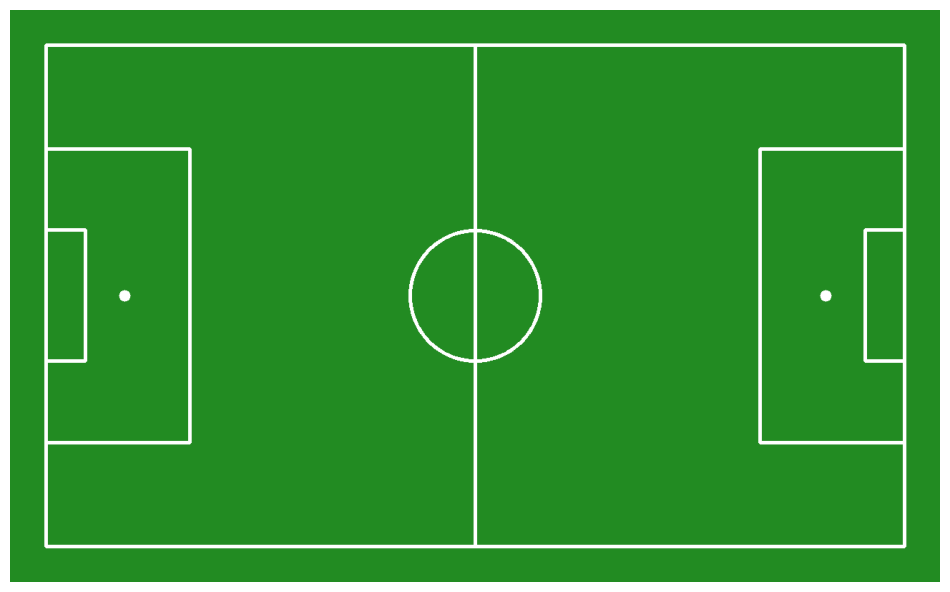

In [10]:
CONFIG=SoccerPitchConfiguration()
annotated_frame=draw_pitch(CONFIG)
sv.plot_image(annotated_frame)

In [4]:
class ViewTransformer:
    def __init__(self,source: np.ndarray, target: np.ndarray):
        source=source.astype(np.float32)
        target=target.astype(np.float32)

        self.m,_=cv2.findHomography(source,target)

    def transform_points(self,points:np.ndarray)->np.ndarray:
        if points.size == 0:
            return points

        reshaped_points=points.reshape(-1,1,2).astype(np.float32) #expand the dimensionality of points from 2d to 3d plane as homography matrix is 3*3 matrix
        points=cv2.perspectiveTransform(reshaped_points,self.m)

        return points.reshape(-1,2).astype(np.float32)

In [39]:
# Define annotators
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2,
    edges=CONFIG.edges
)

vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8
)

# Setup video processing
video_sink = sv.VideoSink(target_playarea_video_path, video_info=video_info)
frame_generator = sv.get_video_frames_generator(src_video_path)

with video_sink:
    for i, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames)):
        # Infer keypoints
        
        result = model.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)
        
        
        # result=model(frame,conf=0.3)[0]
        # key_points=sv.KeyPoints.from_ultralytics(result)

        # Filter keypoints by confidence
        filter_mask = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter_mask]
        frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

        pitch_reference_points = np.array(CONFIG.vertices)[filter_mask]

        view_tranformer = ViewTransformer(
            source=pitch_reference_points,
            target=frame_reference_points
        )

        pitch_all_points = np.array(CONFIG.vertices)
        frame_all_points = view_tranformer.transform_points(pitch_all_points)
        frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_key_points)
        annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_key_points)
        annotated_frame = vertex_annotator_2.annotate(scene=annotated_frame, key_points=frame_all_key_points)

        # Write annotated frame to output video
        video_sink.write_frame(annotated_frame)
        print(f"done for {i}th frame")

print("Processing complete. Output saved at:", target_playarea_video_path)

  0%|          | 0/750 [00:00<?, ?it/s]

done for 0th frame
done for 1th frame
done for 2th frame
done for 3th frame
done for 4th frame
done for 5th frame
done for 6th frame
done for 7th frame
done for 8th frame
done for 9th frame
done for 10th frame
done for 11th frame
done for 12th frame
done for 13th frame
done for 14th frame
done for 15th frame
done for 16th frame
done for 17th frame
done for 18th frame
done for 19th frame
done for 20th frame
done for 21th frame
done for 22th frame
done for 23th frame
done for 24th frame
done for 25th frame
done for 26th frame
done for 27th frame
done for 28th frame
done for 29th frame
done for 30th frame
done for 31th frame
done for 32th frame
done for 33th frame
done for 34th frame
done for 35th frame
done for 36th frame
done for 37th frame
done for 38th frame
done for 39th frame
done for 40th frame
done for 41th frame
done for 42th frame
done for 43th frame
done for 44th frame
done for 45th frame
done for 46th frame
done for 47th frame
done for 48th frame
done for 49th frame
done for 5

In [5]:
def extract_crops(src_video_path:str):
    stride=100
    frame_generator=sv.get_video_frames_generator(src_video_path,stride=stride)
    crops=[]
    Player_id=2

    for frame in tqdm(frame_generator, desc='collecting crops', leave=False):
        result= detection_model(frame,conf=0.3)[0]
        detections=sv.Detections.from_ultralytics(result)
        detections=detections.with_nms(threshold=0.5,class_agnostic=True)
        detections=detections[detections.class_id == Player_id]
        crops+=[
            sv.crop_image(frame,xyxy)
            for xyxy
            in detections.xyxy
        ]
    return crops

def resolve_goalkeepers_team_id(players_detections: sv.Detections, goalkeepers_detections:sv.Detections):
    # using the assumption the midfielder and defense closer to the goalkeeper and thus on average goolkeeper will be closer to its overall mean value

    goalkeepers_xy=goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy=players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    team_0_centeroid = players_xy[players_detections.class_id==0].mean(axis=0)
    team_1_centeroid = players_xy[players_detections.class_id==1].mean(axis=0)

    goalkeepers_team_ids=[]
    for xy in goalkeepers_xy:
        dist_0=np.linalg.norm(xy-team_0_centeroid)
        dist_1=np.linalg.norm(xy-team_1_centeroid)

        goalkeepers_team_ids.append(0 if dist_0<dist_1 else 1)


    return np.array(goalkeepers_team_ids)

In [6]:
crops=extract_crops(src_video_path)

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 20 players, 3 referees, 683.5ms
Speed: 52.6ms preprocess, 683.5ms inference, 56.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 18.4ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 25.2ms
Speed: 15.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 16.9ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 15.1ms preprocess, 25.2ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 28.7ms
Speed: 20.3ms preprocess, 28.7ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 18.0ms prepr

In [7]:
print(len(crops))

159


In [8]:
team_classifier=TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

Embedding extraction: 5it [00:00,  5.31it/s]



0: 736x1280 1 ball, 19 players, 3 referees, 25.4ms
Speed: 16.5ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00, 10.06it/s]


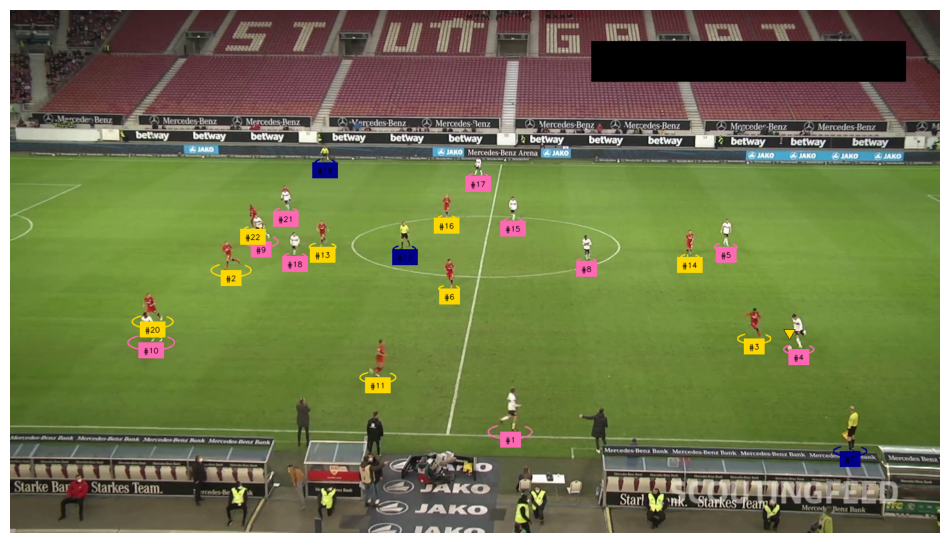

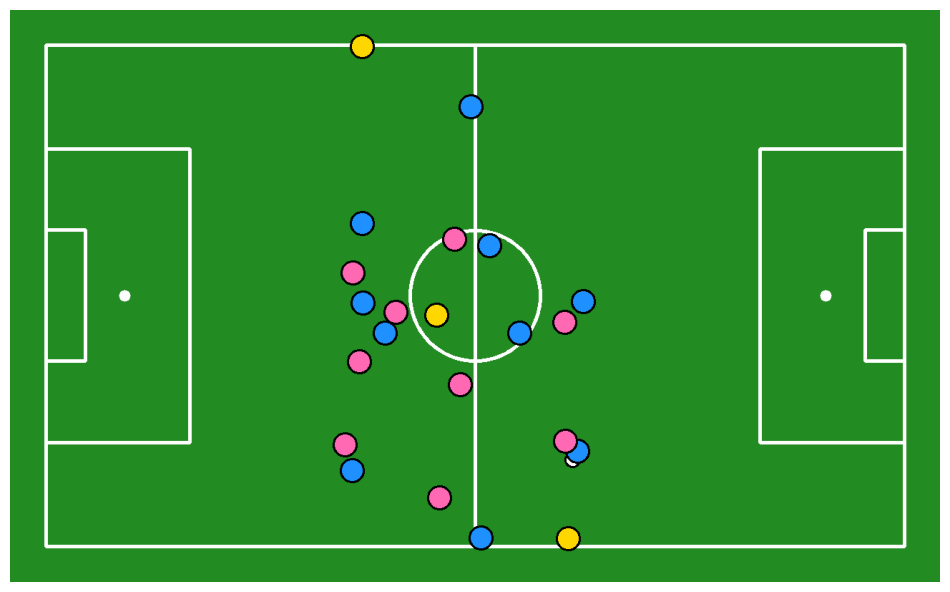

In [44]:
ball_id = 0
goalkeeper_id=1
player_id =  2
referee_id=3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#1E90FF', '#FF69B4', '#FFD700', '#00008B', '#8B008B']),
    thickness=2
)


label_annotator=sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#1E90FF', '#FF69B4', '#FFD700', '#00008B', '#8B008B']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER

)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker=sv.ByteTrack(lost_track_buffer=50, frame_rate=25, minimum_consecutive_frames=1, minimum_matching_threshold=1.2)
tracker.reset()

# getting the detections
result = detection_model(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)


ball_detections = detections[detections.class_id == ball_id]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

# # detections except ball
all_detections = detections[detections.class_id != ball_id]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections=tracker.update_with_detections(all_detections)

# getting the players from detections
players_detections=all_detections[all_detections.class_id==player_id]
goalkeepers_detections=all_detections[all_detections.class_id==goalkeeper_id]
referees_detections=all_detections[all_detections.class_id==referee_id]

players_crops=[sv.crop_image(frame,xyxy) for xyxy in players_detections.xyxy] # cropping each player detections in image
players_detections.class_id=team_classifier.predict(players_crops)+1
goalkeepers_detections.class_id=resolve_goalkeepers_team_id(players_detections,goalkeepers_detections)+4

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections
])


# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)



players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])


# result=model(frame,conf=0.3)[0]
# key_points=sv.KeyPoints.from_ultralytics(result)

result=model.infer(frame,confidence=0.3)[0]
key_points=sv.KeyPoints.from_inference(result)



filter=key_points.confidence[0]>0.5  #gives a boolean filter based on indicies of points which one to take and which one to not
frame_reference_points=key_points.xy[0][filter]
frame_reference_key_points=sv.KeyPoints(xy=frame_reference_points[np.newaxis,...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]


# as now we want point to be projected from camera perspective to pitch perspective
view_tranformer=ViewTransformer(
    source=frame_reference_points,#the points on the 3d frame which were predicted
    target=pitch_reference_points #the 2d pitch we have
)


# for ball
frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = view_tranformer.transform_points(frame_ball_xy)   #going from camera frame to pitch_frame


# for player
frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = view_tranformer.transform_points(frame_players_xy)

# for referees
frame_referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = view_tranformer.transform_points(frame_referees_xy)


annotated_frame=draw_pitch(config=CONFIG) #gets the entire layout

annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame

    )


annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('#1E90FF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame
)

annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id==2],
    face_color=sv.Color.from_hex('#FF69B4'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame

)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 4],
    face_color=sv.Color.from_hex('#00008B'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame
)

annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id==5],
    face_color=sv.Color.from_hex('#8B008B'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame

)

pitch = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_referees_xy,
        face_color=sv.Color.from_hex("FFD700"),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
)


sv.plot_image(annotated_frame)

In [21]:
from collections import defaultdict, deque
import csv


f = 100
object_id_history = defaultdict(lambda: deque(maxlen=f))

ball_id = 0
goalkeeper_id=1
player_id =  2
referee_id=3

no_ball_init=0
no_ball_final=0

# for ellipse and label the first 2 are for the players for two teams respectively and the last color is for referee
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#1E90FF', '#FF69B4', '#FFD700', '#00008B', '#8B008B']),
    thickness=2
)

label_annotator=sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#1E90FF', '#FF69B4', '#FFD700', '#00008B', '#8B008B']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER

)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
)

tracker=sv.ByteTrack(lost_track_buffer=50, frame_rate=25, minimum_consecutive_frames=1, minimum_matching_threshold=1.2)
tracker.reset()

# getting the frame
video_info=sv.VideoInfo.from_video_path(src_video_path)
video_sink=sv.VideoSink(target_tracker_video_path,video_info=video_info)
video_sink_2=sv.VideoSink(target_projection_video_path,video_info=video_info)
frame_generator=sv.get_video_frames_generator(src_video_path)


target_height = video_info.height
target_width = video_info.width



# Define TXT file path
txt_file_path = "tracking_data.txt"

with video_sink, video_sink_2, open(txt_file_path, mode='w') as file:
    

    for i,frame in enumerate(tqdm(frame_generator,total=video_info.total_frames)):

        # frame=frame.to(device)
        frame_tensor = torch.from_numpy(frame).to(DEVICE)

        frame_tensor = frame_tensor.float() / 255.0  # Normalize if model expects values in [0,1]
        frame_tensor = frame_tensor.permute(2, 0, 1)  #

        # getting the detections
        result = detection_model(frame, conf=0.3)[0]
        detections = sv.Detections.from_ultralytics(result)

        ball_detections = detections[detections.class_id == ball_id]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        # New part added
        if len(ball_detections)==0:
            no_ball_init+=1
            print("No ball detected.")
            only_balls_result = only_balls_model(frame, conf=0.3)[0]
            only_balls_detections = sv.Detections.from_ultralytics(only_balls_result)
            ball_detections = only_balls_detections[only_balls_detections.class_id == ball_id]
        if len(ball_detections)==0:
            print("still no ball detected!")
            no_ball_final+=1
        else:
            max_conf_idx = ball_detections.confidence.argmax()
            print("Max confidence ball found in new model:",ball_detections.confidence.max())
            ball_detections = ball_detections[max_conf_idx:max_conf_idx+1]
            ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        

        # detections except ball
        all_detections = detections[detections.class_id != ball_id]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections=tracker.update_with_detections(all_detections)

        # getting the players from detections
        players_detections=all_detections[all_detections.class_id==player_id]
        goalkeepers_detections=all_detections[all_detections.class_id==goalkeeper_id]
        referees_detections=all_detections[all_detections.class_id==referee_id]

        players_crops=[sv.crop_image(frame,xyxy) for xyxy in players_detections.xyxy] # cropping each player detections in image
        players_detections.class_id=team_classifier.predict(players_crops)+1
        goalkeepers_detections.class_id=resolve_goalkeepers_team_id(players_detections,goalkeepers_detections)+4

        all_detections=sv.Detections.merge([players_detections,goalkeepers_detections,referees_detections])

        # New code
        for det_idx, tracker_id in enumerate(all_detections.tracker_id):
            current_class_id = all_detections.class_id[det_idx]
            if current_class_id not in {4, 5}:
              object_id_history[tracker_id].append(current_class_id)

              most_common_class_id = max(set(object_id_history[tracker_id]), key=object_id_history[tracker_id].count)

              all_detections.class_id[det_idx] = most_common_class_id

        labels = [f"#{tracker_id}"  for tracker_id in all_detections.tracker_id]

        all_detections.class_id = all_detections.class_id.astype(int)


        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame,detections=all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame,detections=ball_detections)
        annotated_frame= label_annotator.annotate(scene=annotated_frame,detections=all_detections,labels=labels)

        video_sink.write_frame(annotated_frame)

        

        # result=model(frame,conf=0.3)[0]
        # key_points=sv.KeyPoints.from_ultralytics(result)

        result=model.infer(frame,confidence=0.3)[0]
        key_points=sv.KeyPoints.from_inference(result)


        filter=key_points.confidence[0]>0.5  #gives a boolean filter based on indicies of points which one to take and which one to not
        frame_reference_points=key_points.xy[0][filter]
        frame_reference_key_points=sv.KeyPoints(xy=frame_reference_points[np.newaxis,...])
        pitch_reference_points = np.array(CONFIG.vertices)[filter]




        # as now we want point to be projected from camera perspective to pitch perspective
        view_tranformer=ViewTransformer(
        source=frame_reference_points,#the points on the 3d frame which were predicted
        target=pitch_reference_points #the 2d pitch we have
        )
    
    
        players_detections = sv.Detections.merge([players_detections, goalkeepers_detections])



        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = view_tranformer.transform_points(frame_ball_xy)   #going from camera frame to pitch_frame



        frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = view_tranformer.transform_points(frame_players_xy)


        frame_referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = view_tranformer.transform_points(frame_referees_xy)


        row_data = []

        if len(frame_ball_xy) > 0:
            ball_data = f"{pitch_ball_xy[0][0]} {pitch_ball_xy[0][1]} {ball_id} -1"
        
        row_data.append(ball_data)
        
        goalkeepers_data=[]
        players_data=[]
        for j in range(len(pitch_players_xy)):
            if players_detections.class_id[1] == 4 or players_detections.class_id[1] == 5:
                goalkeepers_data.append(f"{pitch_players_xy[j][0]} {pitch_players_xy[j][1]} {players_detections.class_id[j]} {players_detections.tracker_id[j]}")
            else:
                players_data.append(f"{pitch_players_xy[j][0]} {pitch_players_xy[j][1]} {players_detections.class_id[j]} {players_detections.tracker_id[j]}")
        
        row_data.append(",".join(players_data))
        row_data.append(",".join(goalkeepers_data))        

        referees_data = [f"{pitch_referees_xy[j][0]} {pitch_referees_xy[j][1]} {referees_detections.class_id[j]} {referees_detections.tracker_id[j]}" 
                          for j in range(len(pitch_referees_xy))]
        
        row_data.append(",".join(referees_data))
        
        file.write(",".join(row_data) + "\n")


        annotated_frame=draw_pitch(config=CONFIG)


        annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame

        )
        annotated_frame = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_players_xy[players_detections.class_id == 1],
                face_color=sv.Color.from_hex('#1E90FF'),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=annotated_frame
            )

        annotated_frame = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_players_xy[players_detections.class_id==2],
                face_color=sv.Color.from_hex('#FF69B4'),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=annotated_frame

            )
        annotated_frame = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_players_xy[players_detections.class_id == 4],
                face_color=sv.Color.from_hex('#00008B'),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=annotated_frame
            )

        annotated_frame = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_players_xy[players_detections.class_id==5],
                face_color=sv.Color.from_hex('#8B008B'),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=annotated_frame

            )

        pitch = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_referees_xy,
                face_color=sv.Color.from_hex("FFD700"),
                edge_color=sv.Color.BLACK,
                radius=12,
                pitch=annotated_frame
        )


        resized_annotated_frame = cv2.resize(annotated_frame, (target_width, target_height))
        # resized_annotated_frame = cv2.cvtColor(resized_annotated_frame, cv2.COLOR_BGR2RGB)
        video_sink_2.write_frame(frame=resized_annotated_frame)

        print(f"done for {i}th frame")


print("Analysis file created successfully.")

  0%|          | 0/750 [00:00<?, ?it/s]


0: 736x1280 20 players, 3 referees, 39.7ms
Speed: 9.8ms preprocess, 39.7ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 32.1ms
Speed: 16.4ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.94it/s]


done for 0th frame

0: 736x1280 20 players, 3 referees, 35.6ms
Speed: 10.9ms preprocess, 35.6ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 41.0ms
Speed: 9.7ms preprocess, 41.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.17it/s]


done for 1th frame

0: 736x1280 20 players, 3 referees, 36.0ms
Speed: 11.0ms preprocess, 36.0ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 9.8ms preprocess, 25.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.36it/s]


done for 2th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.1ms
Speed: 6.2ms preprocess, 25.1ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6887345


Embedding extraction: 1it [00:00, 10.85it/s]


done for 3th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 9.1ms preprocess, 25.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.54775983


Embedding extraction: 1it [00:00,  8.27it/s]


done for 4th frame

0: 736x1280 1 ball, 20 players, 3 referees, 31.0ms
Speed: 9.2ms preprocess, 31.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.92556024


Embedding extraction: 1it [00:00,  5.98it/s]


done for 5th frame

0: 736x1280 1 ball, 20 players, 3 referees, 45.6ms
Speed: 10.7ms preprocess, 45.6ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8723712


Embedding extraction: 1it [00:00,  6.38it/s]


done for 6th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 10.3ms preprocess, 25.3ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.46333706


Embedding extraction: 1it [00:00,  4.25it/s]


done for 7th frame

0: 736x1280 19 players, 3 referees, 25.2ms
Speed: 8.7ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.7ms preprocess, 25.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.84it/s]


done for 8th frame

0: 736x1280 1 ball, 19 players, 3 referees, 24.7ms
Speed: 8.6ms preprocess, 24.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.46298018


Embedding extraction: 1it [00:00,  9.43it/s]


done for 9th frame

0: 736x1280 18 players, 3 referees, 24.7ms
Speed: 11.2ms preprocess, 24.7ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 38.1ms
Speed: 8.1ms preprocess, 38.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5224763


Embedding extraction: 1it [00:00,  6.16it/s]


done for 10th frame

0: 736x1280 19 players, 3 referees, 28.9ms
Speed: 10.2ms preprocess, 28.9ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 48.6ms
Speed: 18.5ms preprocess, 48.6ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.402241


Embedding extraction: 1it [00:00,  7.13it/s]


done for 11th frame

0: 736x1280 18 players, 3 referees, 25.4ms
Speed: 9.3ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 53.1ms
Speed: 29.4ms preprocess, 53.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.78it/s]


done for 12th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.47160682


Embedding extraction: 1it [00:00, 11.07it/s]


done for 13th frame

0: 736x1280 20 players, 3 referees, 27.3ms
Speed: 11.5ms preprocess, 27.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 48.0ms
Speed: 6.7ms preprocess, 48.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.56it/s]


done for 14th frame

0: 736x1280 1 ball, 21 players, 3 referees, 48.4ms
Speed: 10.5ms preprocess, 48.4ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5390095


Embedding extraction: 1it [00:00,  6.80it/s]


done for 15th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.8ms
Speed: 10.4ms preprocess, 28.8ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.711252


Embedding extraction: 1it [00:00,  3.59it/s]


done for 16th frame

0: 736x1280 1 ball, 20 players, 4 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.81487495


Embedding extraction: 1it [00:00, 10.32it/s]


done for 17th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 7.5ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.12it/s]


done for 18th frame

0: 736x1280 1 ball, 20 players, 4 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.62235785


Embedding extraction: 1it [00:00,  7.33it/s]


done for 19th frame

0: 736x1280 1 ball, 20 players, 4 referees, 35.7ms
Speed: 12.1ms preprocess, 35.7ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7467314


Embedding extraction: 1it [00:00,  4.97it/s]


done for 20th frame

0: 736x1280 1 ball, 20 players, 4 referees, 68.8ms
Speed: 12.3ms preprocess, 68.8ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.83389354


Embedding extraction: 1it [00:00,  4.40it/s]


done for 21th frame

0: 736x1280 1 ball, 20 players, 4 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5017836


Embedding extraction: 1it [00:00, 10.02it/s]


done for 22th frame

0: 736x1280 1 ball, 20 players, 4 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6423681


Embedding extraction: 1it [00:00,  9.59it/s]


done for 23th frame

0: 736x1280 20 players, 4 referees, 30.5ms
Speed: 8.6ms preprocess, 30.5ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 29.9ms
Speed: 9.3ms preprocess, 29.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.33it/s]


done for 24th frame

0: 736x1280 1 ball, 20 players, 4 referees, 25.3ms
Speed: 10.7ms preprocess, 25.3ms inference, 5.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.74245834


Embedding extraction: 1it [00:00,  7.39it/s]


done for 25th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.9ms
Speed: 9.0ms preprocess, 25.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.77905554


Embedding extraction: 1it [00:00,  6.41it/s]


done for 26th frame

0: 736x1280 1 ball, 20 players, 3 referees, 39.0ms
Speed: 11.8ms preprocess, 39.0ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7620723


Embedding extraction: 1it [00:00,  4.27it/s]


done for 27th frame

0: 736x1280 1 ball, 20 players, 4 referees, 26.3ms
Speed: 8.6ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7894879


Embedding extraction: 1it [00:00,  8.77it/s]


done for 28th frame

0: 736x1280 1 ball, 20 players, 3 referees, 39.7ms
Speed: 8.7ms preprocess, 39.7ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.82887983


Embedding extraction: 1it [00:00,  7.17it/s]


done for 29th frame

0: 736x1280 1 ball, 20 players, 3 referees, 31.7ms
Speed: 8.5ms preprocess, 31.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.83844894


Embedding extraction: 1it [00:00,  6.23it/s]


done for 30th frame

0: 736x1280 1 ball, 20 players, 3 referees, 27.4ms
Speed: 9.2ms preprocess, 27.4ms inference, 6.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6487561


Embedding extraction: 1it [00:00,  7.34it/s]


done for 31th frame

0: 736x1280 1 ball, 20 players, 3 referees, 46.2ms
Speed: 9.4ms preprocess, 46.2ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.68183565


Embedding extraction: 1it [00:00,  6.87it/s]


done for 32th frame

0: 736x1280 1 ball, 20 players, 4 referees, 27.7ms
Speed: 11.9ms preprocess, 27.7ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.74181634


Embedding extraction: 1it [00:00,  5.08it/s]


done for 33th frame

0: 736x1280 1 ball, 20 players, 3 referees, 29.4ms
Speed: 8.6ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.78799313


Embedding extraction: 1it [00:00,  7.92it/s]


done for 34th frame

0: 736x1280 1 ball, 20 players, 3 referees, 27.2ms
Speed: 9.0ms preprocess, 27.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.80498415


Embedding extraction: 1it [00:00,  7.32it/s]


done for 35th frame

0: 736x1280 1 ball, 21 players, 3 referees, 31.2ms
Speed: 8.8ms preprocess, 31.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.54089403


Embedding extraction: 1it [00:00,  6.50it/s]


done for 36th frame

0: 736x1280 2 balls, 20 players, 3 referees, 49.9ms
Speed: 9.0ms preprocess, 49.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7588314


Embedding extraction: 1it [00:00,  5.64it/s]


done for 37th frame

0: 736x1280 20 players, 3 referees, 43.1ms
Speed: 10.9ms preprocess, 43.1ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 32.6ms
Speed: 20.1ms preprocess, 32.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.21it/s]


done for 38th frame

0: 736x1280 20 players, 3 referees, 31.6ms
Speed: 8.7ms preprocess, 31.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 36.2ms
Speed: 7.5ms preprocess, 36.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.24it/s]


done for 39th frame

0: 736x1280 21 players, 4 referees, 30.1ms
Speed: 9.3ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 29.5ms
Speed: 8.7ms preprocess, 29.5ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.34it/s]


done for 40th frame

0: 736x1280 20 players, 3 referees, 41.5ms
Speed: 10.0ms preprocess, 41.5ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 35.1ms
Speed: 26.3ms preprocess, 35.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.371914


Embedding extraction: 1it [00:00,  6.45it/s]


done for 41th frame

0: 736x1280 1 ball, 20 players, 4 referees, 31.4ms
Speed: 10.4ms preprocess, 31.4ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.31099367


Embedding extraction: 1it [00:00,  7.27it/s]


done for 42th frame

0: 736x1280 1 ball, 21 players, 3 referees, 40.9ms
Speed: 13.8ms preprocess, 40.9ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8724904


Embedding extraction: 1it [00:00,  4.24it/s]


done for 43th frame

0: 736x1280 1 ball, 21 players, 4 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.51481146


Embedding extraction: 1it [00:00, 10.83it/s]


done for 44th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8089635


Embedding extraction: 1it [00:00,  9.13it/s]


done for 45th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.9ms
Speed: 9.8ms preprocess, 25.9ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.69403034


Embedding extraction: 1it [00:00,  5.59it/s]


done for 46th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.5ms
Speed: 10.8ms preprocess, 25.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.736161


Embedding extraction: 1it [00:00,  5.65it/s]


done for 47th frame

0: 736x1280 1 ball, 21 players, 2 referees, 26.4ms
Speed: 8.8ms preprocess, 26.4ms inference, 7.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.69810987


Embedding extraction: 1it [00:00,  4.16it/s]


done for 48th frame

0: 736x1280 1 ball, 21 players, 2 referees, 25.4ms
Speed: 8.6ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5033569


Embedding extraction: 1it [00:00, 10.19it/s]


done for 49th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.2ms
Speed: 8.9ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.39398962


Embedding extraction: 1it [00:00, 10.29it/s]


done for 50th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.42092663


Embedding extraction: 1it [00:00,  7.93it/s]


done for 51th frame

0: 736x1280 19 players, 3 referees, 31.1ms
Speed: 11.0ms preprocess, 31.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 33.6ms
Speed: 13.8ms preprocess, 33.6ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.75it/s]


done for 52th frame

0: 736x1280 19 players, 3 referees, 34.2ms
Speed: 10.1ms preprocess, 34.2ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 32.6ms
Speed: 14.7ms preprocess, 32.6ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.42it/s]


done for 53th frame

0: 736x1280 1 ball, 20 players, 3 referees, 37.8ms
Speed: 11.4ms preprocess, 37.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.38837695


Embedding extraction: 1it [00:00,  3.40it/s]


done for 54th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.2ms
Speed: 9.0ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.59051293


Embedding extraction: 1it [00:00, 10.64it/s]


done for 55th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5752432


Embedding extraction: 1it [00:00,  9.09it/s]


done for 56th frame

0: 736x1280 20 players, 3 referees, 31.8ms
Speed: 14.0ms preprocess, 31.8ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 35.4ms
Speed: 14.1ms preprocess, 35.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.39it/s]


done for 57th frame

0: 736x1280 20 players, 3 referees, 36.2ms
Speed: 12.2ms preprocess, 36.2ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 50.3ms
Speed: 19.6ms preprocess, 50.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.25it/s]


done for 58th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 11.1ms preprocess, 25.4ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8482009


Embedding extraction: 1it [00:00,  3.91it/s]


done for 59th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.45258486


Embedding extraction: 1it [00:00, 10.65it/s]


done for 60th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.69656456


Embedding extraction: 1it [00:00,  9.48it/s]


done for 61th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.54537624


Embedding extraction: 1it [00:00,  7.00it/s]


done for 62th frame

0: 736x1280 1 ball, 20 players, 3 referees, 27.3ms
Speed: 9.2ms preprocess, 27.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7092823


Embedding extraction: 1it [00:00,  7.07it/s]


done for 63th frame

0: 736x1280 1 ball, 20 players, 3 referees, 46.2ms
Speed: 9.5ms preprocess, 46.2ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7105184


Embedding extraction: 1it [00:00,  5.44it/s]


done for 64th frame

0: 736x1280 1 ball, 20 players, 3 referees, 26.8ms
Speed: 11.2ms preprocess, 26.8ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.77102864


Embedding extraction: 1it [00:00,  4.75it/s]


done for 65th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.83533835


Embedding extraction: 1it [00:00, 10.92it/s]


done for 66th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6772866


Embedding extraction: 1it [00:00, 10.01it/s]


done for 67th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.7ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7788533


Embedding extraction: 1it [00:00,  6.35it/s]


done for 68th frame

0: 736x1280 1 ball, 20 players, 3 referees, 39.3ms
Speed: 11.3ms preprocess, 39.3ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.71527296


Embedding extraction: 1it [00:00,  5.46it/s]


done for 69th frame

0: 736x1280 1 ball, 20 players, 3 referees, 34.3ms
Speed: 11.3ms preprocess, 34.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.778234


Embedding extraction: 1it [00:00,  5.14it/s]


done for 70th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.75490797


Embedding extraction: 1it [00:00, 10.60it/s]


done for 71th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 8.4ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7212528


Embedding extraction: 1it [00:00, 10.93it/s]


done for 72th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.7ms
Speed: 8.7ms preprocess, 25.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7806452


Embedding extraction: 1it [00:00,  7.71it/s]


done for 73th frame

0: 736x1280 1 ball, 20 players, 3 referees, 27.9ms
Speed: 9.0ms preprocess, 27.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.72575265


Embedding extraction: 1it [00:00,  5.32it/s]


done for 74th frame

0: 736x1280 1 ball, 20 players, 3 referees, 37.1ms
Speed: 10.4ms preprocess, 37.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7238813


Embedding extraction: 1it [00:00,  5.07it/s]


done for 75th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6918732


Embedding extraction: 1it [00:00, 10.54it/s]


done for 76th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.54630184


Embedding extraction: 1it [00:00, 10.79it/s]


done for 77th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.80659586


Embedding extraction: 1it [00:00,  8.73it/s]


done for 78th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8171523


Embedding extraction: 1it [00:00,  7.61it/s]


done for 79th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.75630593


Embedding extraction: 1it [00:00,  4.35it/s]


done for 80th frame

0: 736x1280 1 ball, 20 players, 3 referees, 31.1ms
Speed: 10.4ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.80415


Embedding extraction: 1it [00:00,  3.36it/s]


done for 81th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.85411227


Embedding extraction: 1it [00:00, 10.17it/s]


done for 82th frame

0: 736x1280 1 ball, 20 players, 4 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.82188696


Embedding extraction: 1it [00:00,  9.09it/s]


done for 83th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8686691


Embedding extraction: 1it [00:00,  6.96it/s]


done for 84th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 13.0ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.79962724


Embedding extraction: 1it [00:00,  7.60it/s]


done for 85th frame

0: 736x1280 1 ball, 20 players, 3 referees, 30.6ms
Speed: 12.3ms preprocess, 30.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.719193


Embedding extraction: 1it [00:00,  6.51it/s]


done for 86th frame

0: 736x1280 1 ball, 20 players, 3 referees, 26.4ms
Speed: 12.9ms preprocess, 26.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.56496686


Embedding extraction: 1it [00:00,  4.48it/s]


done for 87th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.41559955


Embedding extraction: 1it [00:00, 10.53it/s]


done for 88th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.8ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5889113


Embedding extraction: 1it [00:00, 10.22it/s]


done for 89th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.49062073


Embedding extraction: 1it [00:00,  9.33it/s]


done for 90th frame

0: 736x1280 1 ball, 20 players, 3 referees, 38.8ms
Speed: 13.9ms preprocess, 38.8ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.65274435


Embedding extraction: 1it [00:00,  6.36it/s]


done for 91th frame

0: 736x1280 20 players, 3 referees, 36.5ms
Speed: 9.2ms preprocess, 36.5ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 32.8ms
Speed: 10.0ms preprocess, 32.8ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.99it/s]


done for 92th frame

0: 736x1280 20 players, 3 referees, 28.2ms
Speed: 10.0ms preprocess, 28.2ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 26.9ms
Speed: 15.2ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.371092


Embedding extraction: 1it [00:00,  4.65it/s]


done for 93th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.5ms preprocess, 25.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.50it/s]


done for 94th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 12.2ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 7.3ms preprocess, 25.3ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.33832878


Embedding extraction: 1it [00:00,  9.33it/s]


done for 95th frame

0: 736x1280 20 players, 3 referees, 27.4ms
Speed: 9.2ms preprocess, 27.4ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 37.6ms
Speed: 16.5ms preprocess, 37.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.27it/s]


done for 96th frame

0: 736x1280 20 players, 3 referees, 34.7ms
Speed: 11.2ms preprocess, 34.7ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 13.1ms preprocess, 25.3ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.43it/s]


done for 97th frame

0: 736x1280 20 players, 3 referees, 41.3ms
Speed: 13.4ms preprocess, 41.3ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 47.7ms
Speed: 19.1ms preprocess, 47.7ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.42874253


Embedding extraction: 1it [00:00,  4.14it/s]


done for 98th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 6.6ms preprocess, 25.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.41687372


Embedding extraction: 1it [00:00, 10.80it/s]


done for 99th frame

0: 736x1280 1 ball, 20 players, 3 referees, 24.8ms
Speed: 9.5ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.88191277


Embedding extraction: 1it [00:00,  9.77it/s]


done for 100th frame

0: 736x1280 1 ball, 20 players, 3 referees, 24.8ms
Speed: 8.6ms preprocess, 24.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7992138


Embedding extraction: 1it [00:00,  9.03it/s]


done for 101th frame

0: 736x1280 1 ball, 20 players, 3 referees, 34.2ms
Speed: 9.9ms preprocess, 34.2ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7383643


Embedding extraction: 1it [00:00,  6.35it/s]


done for 102th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 10.5ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.88872445


Embedding extraction: 1it [00:00,  5.73it/s]


done for 103th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.73406124


Embedding extraction: 1it [00:00,  4.40it/s]


done for 104th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.83081245


Embedding extraction: 1it [00:00, 10.47it/s]


done for 105th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6736711


Embedding extraction: 1it [00:00, 10.07it/s]


done for 106th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7221291


Embedding extraction: 1it [00:00,  8.77it/s]


done for 107th frame

0: 736x1280 1 ball, 21 players, 2 referees, 30.0ms
Speed: 10.5ms preprocess, 30.0ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.66776174


Embedding extraction: 1it [00:00,  6.26it/s]


done for 108th frame

0: 736x1280 1 ball, 20 players, 3 referees, 29.9ms
Speed: 10.2ms preprocess, 29.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.76134014


Embedding extraction: 1it [00:00,  5.61it/s]


done for 109th frame

0: 736x1280 1 ball, 20 players, 3 referees, 31.4ms
Speed: 10.4ms preprocess, 31.4ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8166938


Embedding extraction: 1it [00:00,  4.41it/s]


done for 110th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7785263


Embedding extraction: 1it [00:00, 10.62it/s]


done for 111th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.7ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8151905


Embedding extraction: 1it [00:00,  9.33it/s]


done for 112th frame

0: 736x1280 1 ball, 20 players, 3 referees, 32.6ms
Speed: 11.0ms preprocess, 32.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8011632


Embedding extraction: 1it [00:00,  6.11it/s]


done for 113th frame

0: 736x1280 1 ball, 21 players, 3 referees, 43.7ms
Speed: 11.1ms preprocess, 43.7ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5987506


Embedding extraction: 1it [00:00,  5.92it/s]


done for 114th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.4ms
Speed: 9.8ms preprocess, 25.4ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.63801855


Embedding extraction: 1it [00:00,  3.80it/s]


done for 115th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.65924925


Embedding extraction: 1it [00:00, 10.67it/s]


done for 116th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7615598


Embedding extraction: 1it [00:00,  9.65it/s]


done for 117th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6505089


Embedding extraction: 1it [00:00,  8.43it/s]


done for 118th frame

0: 736x1280 1 ball, 20 players, 3 referees, 26.0ms
Speed: 8.9ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6395483


Embedding extraction: 1it [00:00,  8.75it/s]


done for 119th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.44965148


Embedding extraction: 1it [00:00,  5.13it/s]


done for 120th frame

0: 736x1280 1 ball, 20 players, 3 referees, 54.2ms
Speed: 12.7ms preprocess, 54.2ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.73305565


Embedding extraction: 1it [00:00,  5.24it/s]


done for 121th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.65184027


Embedding extraction: 1it [00:00, 10.64it/s]


done for 122th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.59801716


Embedding extraction: 1it [00:00,  8.79it/s]


done for 123th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.4ms
Speed: 9.8ms preprocess, 25.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.682133


Embedding extraction: 1it [00:00,  8.26it/s]


done for 124th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 5.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.699313


Embedding extraction: 1it [00:00,  4.72it/s]


done for 125th frame

0: 736x1280 1 ball, 20 players, 3 referees, 71.4ms
Speed: 12.7ms preprocess, 71.4ms inference, 12.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.31157157


Embedding extraction: 1it [00:00,  9.23it/s]


done for 126th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.5ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.17it/s]


done for 127th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 10.6ms preprocess, 25.3ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.4ms
Speed: 9.3ms preprocess, 25.4ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.68it/s]


done for 128th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.2ms
Speed: 8.7ms preprocess, 28.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.35660702


Embedding extraction: 1it [00:00,  5.69it/s]


done for 129th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 10.4ms preprocess, 25.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.79221225


Embedding extraction: 1it [00:00,  4.65it/s]


done for 130th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.79742503


Embedding extraction: 1it [00:00, 10.27it/s]


done for 131th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7997742


Embedding extraction: 1it [00:00, 10.07it/s]


done for 132th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.56455964


Embedding extraction: 1it [00:00,  7.96it/s]


done for 133th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.4ms
Speed: 9.7ms preprocess, 25.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7721673


Embedding extraction: 1it [00:00,  6.53it/s]


done for 134th frame

0: 736x1280 1 ball, 20 players, 3 referees, 53.1ms
Speed: 9.6ms preprocess, 53.1ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.54500693


Embedding extraction: 1it [00:00,  5.69it/s]


done for 135th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.66688204


Embedding extraction: 1it [00:00, 10.54it/s]


done for 136th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 6.4ms preprocess, 25.3ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.35868984


Embedding extraction: 1it [00:00,  9.70it/s]


done for 137th frame

0: 736x1280 1 ball, 20 players, 3 referees, 37.7ms
Speed: 11.9ms preprocess, 37.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.9034259


Embedding extraction: 1it [00:00,  5.94it/s]


done for 138th frame

0: 736x1280 1 ball, 20 players, 4 referees, 25.0ms
Speed: 10.5ms preprocess, 25.0ms inference, 5.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5421622


Embedding extraction: 1it [00:00,  8.60it/s]


done for 139th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 11.5ms preprocess, 25.4ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.50756925


Embedding extraction: 1it [00:00,  3.93it/s]


done for 140th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7039837


Embedding extraction: 1it [00:00, 10.57it/s]


done for 141th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8943995


Embedding extraction: 1it [00:00,  9.08it/s]


done for 142th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 40.0ms
Speed: 15.2ms preprocess, 40.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 32.9ms
Speed: 15.3ms preprocess, 32.9ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.76769686


Embedding extraction: 1it [00:00,  5.56it/s]


done for 143th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 30.1ms
Speed: 12.4ms preprocess, 30.1ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 27.5ms
Speed: 16.4ms preprocess, 27.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5769787


Embedding extraction: 1it [00:00,  6.08it/s]


done for 144th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 27.0ms
Speed: 8.6ms preprocess, 27.0ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 74.3ms
Speed: 16.8ms preprocess, 74.3ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.889409


Embedding extraction: 1it [00:00,  4.45it/s]


done for 145th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 6.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6736403


Embedding extraction: 1it [00:00, 10.73it/s]


done for 146th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 9.0ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 7.3ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3259162


Embedding extraction: 1it [00:00,  9.19it/s]


done for 147th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 25.3ms
Speed: 11.3ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 9.9ms preprocess, 25.3ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.62it/s]


done for 148th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 34.6ms
Speed: 16.2ms preprocess, 34.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 36.5ms
Speed: 18.5ms preprocess, 36.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.64032334


Embedding extraction: 1it [00:00,  5.69it/s]


done for 149th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 27.6ms
Speed: 9.6ms preprocess, 27.6ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 29.8ms
Speed: 13.7ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.95it/s]


done for 150th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 7.1ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.64it/s]


done for 151th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 9.9ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.99it/s]


done for 152th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 25.8ms
Speed: 10.0ms preprocess, 25.8ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 26.5ms
Speed: 19.3ms preprocess, 26.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.51it/s]


done for 153th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 24.8ms
Speed: 9.5ms preprocess, 24.8ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 55.2ms
Speed: 15.6ms preprocess, 55.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.47it/s]


done for 154th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.6ms preprocess, 25.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.01it/s]


done for 155th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 25.2ms
Speed: 8.7ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 26.3ms
Speed: 6.7ms preprocess, 26.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.77it/s]


done for 156th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 31.5ms
Speed: 13.2ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 36.3ms
Speed: 13.5ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.04it/s]


done for 157th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 24.8ms
Speed: 9.5ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7676856


Embedding extraction: 1it [00:00,  4.47it/s]


done for 158th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 4 referees, 75.2ms
Speed: 10.2ms preprocess, 75.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.73446435


Embedding extraction: 1it [00:00, 10.35it/s]


done for 159th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 25.2ms
Speed: 8.7ms preprocess, 25.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.72903365


Embedding extraction: 1it [00:00, 10.73it/s]


done for 160th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 32.1ms
Speed: 11.5ms preprocess, 32.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5503159


Embedding extraction: 1it [00:00,  5.32it/s]


done for 161th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 4 referees, 29.8ms
Speed: 8.6ms preprocess, 29.8ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7737232


Embedding extraction: 1it [00:00,  6.20it/s]


done for 162th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 4 referees, 33.7ms
Speed: 11.6ms preprocess, 33.7ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.64034116


Embedding extraction: 1it [00:00,  3.96it/s]


done for 163th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 4 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7175331


Embedding extraction: 1it [00:00,  9.56it/s]


done for 164th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 4 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7963022


Embedding extraction: 1it [00:00, 10.23it/s]


done for 165th frame

0: 736x1280 2 balls, 1 goalkeeper, 21 players, 3 referees, 38.2ms
Speed: 10.9ms preprocess, 38.2ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7900174


Embedding extraction: 1it [00:00,  5.81it/s]


done for 166th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 31.2ms
Speed: 15.3ms preprocess, 31.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.68131113


Embedding extraction: 1it [00:00,  5.69it/s]


done for 167th frame

0: 736x1280 1 goalkeeper, 21 players, 4 referees, 27.3ms
Speed: 11.3ms preprocess, 27.3ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 50.3ms
Speed: 19.5ms preprocess, 50.3ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.17it/s]


done for 168th frame

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 38.0ms
Speed: 36.0ms preprocess, 38.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.64771855


Embedding extraction: 1it [00:00, 10.60it/s]


done for 169th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4060353


Embedding extraction: 1it [00:00, 10.30it/s]


done for 170th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.50569105


Embedding extraction: 1it [00:00,  8.70it/s]


done for 171th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 29.4ms
Speed: 11.6ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 41.1ms
Speed: 15.2ms preprocess, 41.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.78it/s]


done for 172th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 25.9ms
Speed: 11.4ms preprocess, 25.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.34625563


Embedding extraction: 1it [00:00,  5.30it/s]


done for 173th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 31.8ms
Speed: 13.0ms preprocess, 31.8ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 52.2ms
Speed: 29.6ms preprocess, 52.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.90it/s]


done for 174th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 6.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.32651296


Embedding extraction: 1it [00:00, 10.29it/s]


done for 175th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 9.5ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.39it/s]


done for 176th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 31.6ms
Speed: 9.3ms preprocess, 31.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 43.9ms
Speed: 12.9ms preprocess, 43.9ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.87it/s]


done for 177th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 50.5ms
Speed: 15.2ms preprocess, 50.5ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 70.6ms
Speed: 25.3ms preprocess, 70.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.36it/s]


done for 178th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 7.5ms preprocess, 25.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.45116854


Embedding extraction: 1it [00:00,  9.40it/s]


done for 179th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 7.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 8.3ms preprocess, 25.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.71it/s]


done for 180th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 32.2ms
Speed: 18.3ms preprocess, 32.2ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.31360883


Embedding extraction: 1it [00:00,  7.73it/s]


done for 181th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 4 referees, 25.0ms
Speed: 11.5ms preprocess, 25.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.37163666


Embedding extraction: 1it [00:00,  4.03it/s]


done for 182th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 4 referees, 43.9ms
Speed: 11.0ms preprocess, 43.9ms inference, 6.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.53719336


Embedding extraction: 1it [00:00,  4.52it/s]


done for 183th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 31.0ms
Speed: 16.6ms preprocess, 31.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.44712925


Embedding extraction: 1it [00:00,  8.84it/s]


done for 184th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 8.9ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.56650525


Embedding extraction: 1it [00:00,  7.91it/s]


done for 185th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 43.4ms
Speed: 16.4ms preprocess, 43.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5255914


Embedding extraction: 1it [00:00,  6.92it/s]


done for 186th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 32.4ms
Speed: 13.3ms preprocess, 32.4ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.579985


Embedding extraction: 1it [00:00,  6.36it/s]


done for 187th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 40.8ms
Speed: 12.4ms preprocess, 40.8ms inference, 8.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.71778214


Embedding extraction: 1it [00:00,  3.99it/s]


done for 188th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8603045


Embedding extraction: 1it [00:00, 10.00it/s]


done for 189th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.47410944


Embedding extraction: 1it [00:00,  8.90it/s]


done for 190th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 4 referees, 25.4ms
Speed: 10.4ms preprocess, 25.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7175364


Embedding extraction: 1it [00:00,  8.07it/s]


done for 191th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 38.6ms
Speed: 11.3ms preprocess, 38.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6860526


Embedding extraction: 1it [00:00,  7.15it/s]


done for 192th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 51.9ms
Speed: 19.8ms preprocess, 51.9ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7492415


Embedding extraction: 1it [00:00,  5.75it/s]


done for 193th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 49.7ms
Speed: 13.4ms preprocess, 49.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8060269


Embedding extraction: 1it [00:00,  3.35it/s]


done for 194th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 3 referees, 25.4ms
Speed: 9.6ms preprocess, 25.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8437216


Embedding extraction: 1it [00:00,  9.44it/s]


done for 195th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.59887844


Embedding extraction: 1it [00:00,  8.20it/s]


done for 196th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 44.2ms
Speed: 12.7ms preprocess, 44.2ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.71283853


Embedding extraction: 1it [00:00,  7.02it/s]


done for 197th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 35.0ms
Speed: 11.2ms preprocess, 35.0ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8094795


Embedding extraction: 1it [00:00,  6.88it/s]


done for 198th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 30.3ms
Speed: 11.5ms preprocess, 30.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.79627854


Embedding extraction: 1it [00:00,  4.44it/s]


done for 199th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.58453363


Embedding extraction: 1it [00:00, 10.31it/s]


done for 200th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4403482


Embedding extraction: 1it [00:00,  9.32it/s]


done for 201th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 10.6ms preprocess, 25.3ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5884908


Embedding extraction: 1it [00:00,  7.41it/s]


done for 202th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 32.5ms
Speed: 11.1ms preprocess, 32.5ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.75830406


Embedding extraction: 1it [00:00,  5.35it/s]


done for 203th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 28.2ms
Speed: 23.5ms preprocess, 28.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6591447


Embedding extraction: 1it [00:00, 10.83it/s]


done for 204th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.9ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.45014343


Embedding extraction: 1it [00:00, 11.34it/s]


done for 205th frame

0: 736x1280 2 balls, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5478026


Embedding extraction: 1it [00:00,  8.51it/s]


done for 206th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.4ms
Speed: 14.7ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.4ms
Speed: 9.6ms preprocess, 25.4ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.07it/s]


done for 207th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 28.8ms
Speed: 16.9ms preprocess, 28.8ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 59.9ms
Speed: 20.3ms preprocess, 59.9ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.37373474


Embedding extraction: 1it [00:00,  5.15it/s]


done for 208th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.3ms preprocess, 25.2ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 11.01it/s]


done for 209th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 6.9ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.46475744


Embedding extraction: 1it [00:00,  9.40it/s]


done for 210th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 24.9ms
Speed: 9.0ms preprocess, 24.9ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4072434


Embedding extraction: 1it [00:00,  6.42it/s]


done for 211th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 28.3ms
Speed: 10.1ms preprocess, 28.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6321005


Embedding extraction: 1it [00:00,  5.61it/s]


done for 212th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 53.6ms
Speed: 11.4ms preprocess, 53.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7908159


Embedding extraction: 1it [00:00,  5.61it/s]


done for 213th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.3ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8019794


Embedding extraction: 1it [00:00, 10.60it/s]


done for 214th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7717568


Embedding extraction: 1it [00:00, 10.93it/s]


done for 215th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5161749


Embedding extraction: 1it [00:00,  9.14it/s]


done for 216th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 26.6ms
Speed: 10.3ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7122496


Embedding extraction: 1it [00:00,  7.81it/s]


done for 217th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.8ms
Speed: 11.4ms preprocess, 25.8ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.731675


Embedding extraction: 1it [00:00,  5.72it/s]


done for 218th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 41.6ms
Speed: 15.1ms preprocess, 41.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 69.8ms
Speed: 16.2ms preprocess, 69.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.47it/s]


done for 219th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.6ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.77it/s]


done for 220th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 24.9ms
Speed: 8.9ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 24.9ms
Speed: 7.2ms preprocess, 24.9ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.19it/s]


done for 221th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 34.0ms
Speed: 11.6ms preprocess, 34.0ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.367897


Embedding extraction: 1it [00:00,  7.48it/s]


done for 222th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 29.0ms
Speed: 10.8ms preprocess, 29.0ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3824964


Embedding extraction: 1it [00:00,  6.58it/s]


done for 223th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 34.0ms
Speed: 10.7ms preprocess, 34.0ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.38281652


Embedding extraction: 1it [00:00,  4.49it/s]


done for 224th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.49512503


Embedding extraction: 1it [00:00, 10.45it/s]


done for 225th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.47779974


Embedding extraction: 1it [00:00,  9.20it/s]


done for 226th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.9ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.30018213


Embedding extraction: 1it [00:00,  8.24it/s]


done for 227th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 10.5ms preprocess, 25.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.41936368


Embedding extraction: 1it [00:00,  7.32it/s]


done for 228th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 28.5ms
Speed: 11.0ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.45570645


Embedding extraction: 1it [00:00,  6.97it/s]


done for 229th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 40.6ms
Speed: 10.4ms preprocess, 40.6ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 64.6ms
Speed: 18.3ms preprocess, 64.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.47it/s]


done for 230th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.30806315


Embedding extraction: 1it [00:00, 10.88it/s]


done for 231th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 26.4ms
Speed: 8.5ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3153302


Embedding extraction: 1it [00:00, 10.27it/s]


done for 232th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 37.4ms
Speed: 12.4ms preprocess, 37.4ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5602768


Embedding extraction: 1it [00:00,  6.77it/s]


done for 233th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 30.4ms
Speed: 11.1ms preprocess, 30.4ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.49324125


Embedding extraction: 1it [00:00,  8.73it/s]


done for 234th frame

0: 736x1280 2 balls, 1 goalkeeper, 19 players, 3 referees, 32.7ms
Speed: 10.7ms preprocess, 32.7ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.41616324


Embedding extraction: 1it [00:00,  4.30it/s]


done for 235th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.32115906


Embedding extraction: 1it [00:00, 10.95it/s]


done for 236th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.56it/s]


done for 237th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.4ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 39.6ms
Speed: 17.5ms preprocess, 39.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3256776


Embedding extraction: 1it [00:00,  5.55it/s]


done for 238th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 27.1ms
Speed: 9.6ms preprocess, 27.1ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 35.4ms
Speed: 18.4ms preprocess, 35.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.97it/s]


done for 239th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 4 referees, 25.4ms
Speed: 13.5ms preprocess, 25.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.62562305


Embedding extraction: 1it [00:00,  5.27it/s]


done for 240th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 4 referees, 58.0ms
Speed: 17.8ms preprocess, 58.0ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.80847085


Embedding extraction: 1it [00:00, 10.45it/s]


done for 241th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 4 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.86485606


Embedding extraction: 1it [00:00, 10.70it/s]


done for 242th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 4 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.76058084


Embedding extraction: 1it [00:00, 10.32it/s]


done for 243th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 28.3ms
Speed: 11.5ms preprocess, 28.3ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.88843703


Embedding extraction: 1it [00:00,  5.64it/s]


done for 244th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.4ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.9167645


Embedding extraction: 1it [00:00,  6.69it/s]


done for 245th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 4 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.9102615


Embedding extraction: 1it [00:00,  4.61it/s]


done for 246th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 41.7ms
Speed: 10.5ms preprocess, 41.7ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7241691


Embedding extraction: 1it [00:00,  5.50it/s]


done for 247th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8331071


Embedding extraction: 1it [00:00, 10.92it/s]


done for 248th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5125115


Embedding extraction: 1it [00:00,  8.63it/s]


done for 249th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 27.5ms
Speed: 9.4ms preprocess, 27.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 11.8ms preprocess, 25.3ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.99it/s]


done for 250th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.9ms preprocess, 25.3ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 27.5ms
Speed: 13.5ms preprocess, 27.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.30786356


Embedding extraction: 1it [00:00,  4.82it/s]


done for 251th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7197173


Embedding extraction: 1it [00:00, 10.81it/s]


done for 252th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 4 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.80667734


Embedding extraction: 1it [00:00, 10.10it/s]


done for 253th frame

0: 736x1280 2 balls, 1 goalkeeper, 20 players, 3 referees, 29.3ms
Speed: 8.7ms preprocess, 29.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.45319566


Embedding extraction: 1it [00:00,  6.81it/s]


done for 254th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 4 referees, 28.7ms
Speed: 13.5ms preprocess, 28.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6999455


Embedding extraction: 1it [00:00,  5.66it/s]


done for 255th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 4 referees, 33.6ms
Speed: 10.5ms preprocess, 33.6ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6581156


Embedding extraction: 1it [00:00,  5.52it/s]


done for 256th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.2ms
Speed: 8.7ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7950215


Embedding extraction: 1it [00:00, 10.77it/s]


done for 257th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.42537397


Embedding extraction: 1it [00:00, 10.39it/s]


done for 258th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.3ms
Speed: 9.6ms preprocess, 25.3ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7032436


Embedding extraction: 1it [00:00,  8.20it/s]


done for 259th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 55.3ms
Speed: 16.7ms preprocess, 55.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4420538


Embedding extraction: 1it [00:00,  6.01it/s]


done for 260th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.2ms
Speed: 18.1ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.79843175


Embedding extraction: 1it [00:00, 10.55it/s]


done for 261th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6975136


Embedding extraction: 1it [00:00, 11.04it/s]


done for 262th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 7.6ms preprocess, 25.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.80it/s]


done for 263th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 31.8ms
Speed: 12.4ms preprocess, 31.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.35783222


Embedding extraction: 1it [00:00,  7.05it/s]


done for 264th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 28.4ms
Speed: 11.8ms preprocess, 28.4ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.69387275


Embedding extraction: 1it [00:00,  6.74it/s]


done for 265th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 35.0ms
Speed: 12.0ms preprocess, 35.0ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6628125


Embedding extraction: 1it [00:00,  4.55it/s]


done for 266th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.71745557


Embedding extraction: 1it [00:00, 10.20it/s]


done for 267th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 4 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5254763


Embedding extraction: 1it [00:00,  9.34it/s]


done for 268th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.35981718


Embedding extraction: 1it [00:00,  8.01it/s]


done for 269th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 28.7ms
Speed: 9.1ms preprocess, 28.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 7.8ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.59168404


Embedding extraction: 1it [00:00,  7.13it/s]


done for 270th frame

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 25.4ms
Speed: 10.8ms preprocess, 25.4ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 48.7ms
Speed: 21.9ms preprocess, 48.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.61615485


Embedding extraction: 1it [00:00,  5.67it/s]


done for 271th frame

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 55.5ms
Speed: 20.6ms preprocess, 55.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.1ms
Speed: 6.7ms preprocess, 25.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3030739


Embedding extraction: 1it [00:00, 10.65it/s]


done for 272th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.4ms preprocess, 25.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.86it/s]


done for 273th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 24.8ms
Speed: 11.5ms preprocess, 24.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 8.2ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.78it/s]


done for 274th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 26.2ms
Speed: 8.6ms preprocess, 26.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.0ms
Speed: 8.1ms preprocess, 25.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.83it/s]


done for 275th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.4ms
Speed: 10.0ms preprocess, 25.4ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 52.2ms
Speed: 22.1ms preprocess, 52.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.95it/s]


done for 276th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.7ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.25it/s]


done for 277th frame

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.9ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.35it/s]


done for 278th frame

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 26.0ms
Speed: 8.5ms preprocess, 26.0ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 27.5ms
Speed: 16.2ms preprocess, 27.5ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.57it/s]


done for 279th frame

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 36.7ms
Speed: 12.1ms preprocess, 36.7ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 31.7ms
Speed: 8.8ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.15it/s]


done for 280th frame

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 60.7ms
Speed: 11.1ms preprocess, 60.7ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 51.3ms
Speed: 23.2ms preprocess, 51.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.47it/s]


done for 281th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6332382


Embedding extraction: 1it [00:00, 10.61it/s]


done for 282th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.62407386


Embedding extraction: 1it [00:00, 10.10it/s]


done for 283th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 32.9ms
Speed: 11.3ms preprocess, 32.9ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.30261365


Embedding extraction: 1it [00:00,  5.88it/s]


done for 284th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 28.0ms
Speed: 11.0ms preprocess, 28.0ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 38.4ms
Speed: 15.3ms preprocess, 38.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5548629


Embedding extraction: 1it [00:00,  6.68it/s]


done for 285th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 40.7ms
Speed: 13.7ms preprocess, 40.7ms inference, 6.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 53.3ms
Speed: 17.8ms preprocess, 53.3ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.45848438


Embedding extraction: 1it [00:00,  4.13it/s]


done for 286th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 7.4ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.48381868


Embedding extraction: 1it [00:00, 10.49it/s]


done for 287th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 11.2ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.50934947


Embedding extraction: 1it [00:00,  9.25it/s]


done for 288th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 12.2ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 7.0ms preprocess, 25.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6524045


Embedding extraction: 1it [00:00,  7.84it/s]


done for 289th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.4ms
Speed: 12.8ms preprocess, 25.4ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 30.5ms
Speed: 11.2ms preprocess, 30.5ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8089023


Embedding extraction: 1it [00:00,  7.94it/s]


done for 290th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 26.0ms
Speed: 13.2ms preprocess, 26.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 33.6ms
Speed: 13.9ms preprocess, 33.6ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.62572044


Embedding extraction: 1it [00:00,  7.34it/s]


done for 291th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 54.4ms
Speed: 15.2ms preprocess, 54.4ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 3 balls, 43.0ms
Speed: 20.7ms preprocess, 43.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8765096


Embedding extraction: 1it [00:00,  3.52it/s]


done for 292th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 6.1ms preprocess, 25.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3090339


Embedding extraction: 1it [00:00, 10.62it/s]


done for 293th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7099002


Embedding extraction: 1it [00:00,  9.23it/s]


done for 294th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 34.4ms
Speed: 10.7ms preprocess, 34.4ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.79587895


Embedding extraction: 1it [00:00,  5.87it/s]


done for 295th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 32.4ms
Speed: 12.9ms preprocess, 32.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.57622874


Embedding extraction: 1it [00:00,  6.41it/s]


done for 296th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.7ms preprocess, 25.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 84.0ms
Speed: 34.3ms preprocess, 84.0ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.30it/s]


done for 297th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.6ms preprocess, 25.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.47it/s]


done for 298th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.7ms preprocess, 25.3ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.42572716


Embedding extraction: 1it [00:00,  5.53it/s]


done for 299th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 37.2ms
Speed: 10.5ms preprocess, 37.2ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7888003


Embedding extraction: 1it [00:00,  5.71it/s]


done for 300th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 47.5ms
Speed: 10.4ms preprocess, 47.5ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6747229


Embedding extraction: 1it [00:00,  6.06it/s]


done for 301th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7147389


Embedding extraction: 1it [00:00, 10.35it/s]


done for 302th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6106437


Embedding extraction: 1it [00:00,  5.39it/s]


done for 303th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 41.1ms
Speed: 11.6ms preprocess, 41.1ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.36516505


Embedding extraction: 1it [00:00,  5.84it/s]


done for 304th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.4ms
Speed: 9.3ms preprocess, 25.4ms inference, 7.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 68.1ms
Speed: 26.2ms preprocess, 68.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.09it/s]


done for 305th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.9ms preprocess, 25.2ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.10it/s]


done for 306th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 24.8ms
Speed: 8.7ms preprocess, 24.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 26.1ms
Speed: 8.8ms preprocess, 26.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.49it/s]


done for 307th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 37.3ms
Speed: 12.8ms preprocess, 37.3ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5171901


Embedding extraction: 1it [00:00,  6.08it/s]


done for 308th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 35.6ms
Speed: 14.1ms preprocess, 35.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.59065676


Embedding extraction: 1it [00:00,  5.88it/s]


done for 309th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 34.2ms
Speed: 10.6ms preprocess, 34.2ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4898717


Embedding extraction: 1it [00:00,  4.50it/s]


done for 310th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5459985


Embedding extraction: 1it [00:00, 10.35it/s]


done for 311th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.54559195


Embedding extraction: 1it [00:00,  7.89it/s]


done for 312th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.4ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 30.5ms
Speed: 9.7ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.97it/s]


done for 313th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 26.1ms
Speed: 12.3ms preprocess, 26.1ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 34.9ms
Speed: 11.6ms preprocess, 34.9ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.88it/s]


done for 314th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.7ms preprocess, 25.3ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.50it/s]


done for 315th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.7ms preprocess, 25.3ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.61it/s]


done for 316th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.7ms
Speed: 7.8ms preprocess, 25.7ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.28it/s]


done for 317th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.4ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.4ms
Speed: 9.6ms preprocess, 25.4ms inference, 6.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.47518316


Embedding extraction: 1it [00:00,  6.48it/s]


done for 318th frame

0: 736x1280 2 balls, 1 goalkeeper, 20 players, 3 referees, 47.7ms
Speed: 11.1ms preprocess, 47.7ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.57358587


Embedding extraction: 1it [00:00,  4.91it/s]


done for 319th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 39.4ms
Speed: 10.0ms preprocess, 39.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7856557


Embedding extraction: 1it [00:00,  4.75it/s]


done for 320th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6938355


Embedding extraction: 1it [00:00, 10.52it/s]


done for 321th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.69085574


Embedding extraction: 1it [00:00,  9.69it/s]


done for 322th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 43.5ms
Speed: 10.4ms preprocess, 43.5ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7475092


Embedding extraction: 1it [00:00,  6.06it/s]


done for 323th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 29.8ms
Speed: 9.7ms preprocess, 29.8ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.9008997


Embedding extraction: 1it [00:00,  5.97it/s]


done for 324th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 29.9ms
Speed: 10.0ms preprocess, 29.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.892465


Embedding extraction: 1it [00:00,  4.76it/s]


done for 325th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 25.3ms
Speed: 6.9ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.41737282


Embedding extraction: 1it [00:00, 10.29it/s]


done for 326th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 24.9ms
Speed: 8.6ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 24.9ms
Speed: 7.4ms preprocess, 24.9ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.66it/s]


done for 327th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 38.4ms
Speed: 10.1ms preprocess, 38.4ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 29.3ms
Speed: 11.7ms preprocess, 29.3ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5170675


Embedding extraction: 1it [00:00,  6.32it/s]


done for 328th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 10.6ms preprocess, 25.3ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 83.1ms
Speed: 19.8ms preprocess, 83.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.22it/s]


done for 329th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.30729952


Embedding extraction: 1it [00:00, 10.46it/s]


done for 330th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7851143


Embedding extraction: 1it [00:00,  9.99it/s]


done for 331th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.9ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5431052


Embedding extraction: 1it [00:00,  6.03it/s]


done for 332th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.5ms
Speed: 11.2ms preprocess, 25.5ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.36493668


Embedding extraction: 1it [00:00,  5.69it/s]


done for 333th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 26.2ms
Speed: 9.7ms preprocess, 26.2ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 50.2ms
Speed: 15.0ms preprocess, 50.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.90it/s]


done for 334th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.55864966


Embedding extraction: 1it [00:00, 10.20it/s]


done for 335th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.43178356


Embedding extraction: 1it [00:00,  9.16it/s]


done for 336th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 36.3ms
Speed: 12.5ms preprocess, 36.3ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 37.3ms
Speed: 13.7ms preprocess, 37.3ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.68it/s]


done for 337th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 11.4ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.44530904


Embedding extraction: 1it [00:00,  5.76it/s]


done for 338th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 47.0ms
Speed: 12.3ms preprocess, 47.0ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.63230395


Embedding extraction: 1it [00:00,  4.64it/s]


done for 339th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.7ms preprocess, 25.2ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.39it/s]


done for 340th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 24.8ms
Speed: 8.5ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.669749


Embedding extraction: 1it [00:00,  9.35it/s]


done for 341th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 28.9ms
Speed: 12.3ms preprocess, 28.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 31.9ms
Speed: 13.5ms preprocess, 31.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.64801186


Embedding extraction: 1it [00:00,  5.38it/s]


done for 342th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 29.1ms
Speed: 11.7ms preprocess, 29.1ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 48.4ms
Speed: 17.5ms preprocess, 48.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.54360706


Embedding extraction: 1it [00:00,  6.01it/s]


done for 343th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.7ms
Speed: 9.3ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 73.9ms
Speed: 31.6ms preprocess, 73.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.94it/s]


done for 344th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.1ms
Speed: 6.4ms preprocess, 25.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.33388913


Embedding extraction: 1it [00:00, 10.26it/s]


done for 345th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 11.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.50772154


Embedding extraction: 1it [00:00,  9.54it/s]


done for 346th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 42.8ms
Speed: 12.8ms preprocess, 42.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 43.6ms
Speed: 11.5ms preprocess, 43.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.49518803


Embedding extraction: 1it [00:00,  7.88it/s]


done for 347th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 37.5ms
Speed: 10.1ms preprocess, 37.5ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7837132


Embedding extraction: 1it [00:00,  7.89it/s]


done for 348th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 53.1ms
Speed: 13.6ms preprocess, 53.1ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5526628


Embedding extraction: 1it [00:00,  4.14it/s]


done for 349th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.49084386


Embedding extraction: 1it [00:00, 10.48it/s]


done for 350th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.49773574


Embedding extraction: 1it [00:00,  9.43it/s]


done for 351th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.4ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 8.3ms preprocess, 25.3ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.06it/s]


done for 352th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.4ms
Speed: 12.1ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.32726082


Embedding extraction: 1it [00:00,  8.76it/s]


done for 353th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.51784855


Embedding extraction: 1it [00:00,  6.28it/s]


done for 354th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.4ms
Speed: 10.0ms preprocess, 25.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.64516884


Embedding extraction: 1it [00:00,  5.16it/s]


done for 355th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.47605938


Embedding extraction: 1it [00:00, 10.50it/s]


done for 356th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.8ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4609327


Embedding extraction: 1it [00:00,  8.92it/s]


done for 357th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 34.1ms
Speed: 12.5ms preprocess, 34.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 41.2ms
Speed: 14.6ms preprocess, 41.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7252524


Embedding extraction: 1it [00:00,  8.13it/s]


done for 358th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 27.6ms
Speed: 9.7ms preprocess, 27.6ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 48.9ms
Speed: 22.1ms preprocess, 48.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.70it/s]


done for 359th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.0ms preprocess, 25.1ms inference, 0.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.73it/s]


done for 360th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.2ms
Speed: 8.8ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 10.6ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.47it/s]


done for 361th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 29.6ms
Speed: 22.8ms preprocess, 29.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.63it/s]


done for 362th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 39.7ms
Speed: 11.1ms preprocess, 39.7ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 13.3ms preprocess, 25.3ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.78it/s]


done for 363th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.5ms
Speed: 11.9ms preprocess, 25.5ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 52.3ms
Speed: 24.4ms preprocess, 52.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.13it/s]


done for 364th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.8ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.14it/s]


done for 365th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 24.8ms
Speed: 8.6ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 24.8ms
Speed: 9.4ms preprocess, 24.8ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.27it/s]


done for 366th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 31.7ms
Speed: 10.2ms preprocess, 31.7ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 36.7ms
Speed: 16.5ms preprocess, 36.7ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.14it/s]


done for 367th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 59.0ms
Speed: 22.1ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.06it/s]


done for 368th frame

0: 736x1280 20 players, 3 referees, 35.6ms
Speed: 9.7ms preprocess, 35.6ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 78.8ms
Speed: 26.7ms preprocess, 78.8ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.26it/s]


done for 369th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 9.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.4ms preprocess, 25.1ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.39it/s]


done for 370th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 9.1ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.6ms preprocess, 25.2ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.33it/s]


done for 371th frame

0: 736x1280 20 players, 4 referees, 25.0ms
Speed: 13.9ms preprocess, 25.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.0ms
Speed: 10.6ms preprocess, 25.0ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.98it/s]


done for 372th frame

0: 736x1280 20 players, 3 referees, 48.2ms
Speed: 9.5ms preprocess, 48.2ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 45.2ms
Speed: 19.7ms preprocess, 45.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.49it/s]


done for 373th frame

0: 736x1280 20 players, 2 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 7.3ms preprocess, 25.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.23it/s]


done for 374th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 7.1ms preprocess, 25.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.94it/s]


done for 375th frame

0: 736x1280 20 players, 3 referees, 29.1ms
Speed: 10.8ms preprocess, 29.1ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 29.5ms
Speed: 14.0ms preprocess, 29.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.15it/s]


done for 376th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 8.5ms preprocess, 24.9ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 62.7ms
Speed: 18.6ms preprocess, 62.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.14it/s]


done for 377th frame

0: 736x1280 20 players, 3 referees, 34.6ms
Speed: 15.4ms preprocess, 34.6ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 43.5ms
Speed: 19.7ms preprocess, 43.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.24it/s]


done for 378th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.6ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.2ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.44it/s]


done for 379th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.03it/s]


done for 380th frame

0: 736x1280 20 players, 3 referees, 33.2ms
Speed: 11.3ms preprocess, 33.2ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 42.7ms
Speed: 13.9ms preprocess, 42.7ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8266775


Embedding extraction: 1it [00:00,  6.83it/s]


done for 381th frame

0: 736x1280 21 players, 3 referees, 25.3ms
Speed: 10.1ms preprocess, 25.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 10.5ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.24it/s]


done for 382th frame

0: 736x1280 21 players, 3 referees, 29.6ms
Speed: 8.7ms preprocess, 29.6ms inference, 7.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 57.0ms
Speed: 26.9ms preprocess, 57.0ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.09it/s]


done for 383th frame

0: 736x1280 21 players, 4 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.6ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.53it/s]


done for 384th frame

0: 736x1280 20 players, 2 referees, 25.2ms
Speed: 8.7ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.5ms
Speed: 6.6ms preprocess, 25.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.63it/s]


done for 385th frame

0: 736x1280 20 players, 2 referees, 34.0ms
Speed: 11.3ms preprocess, 34.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 41.5ms
Speed: 11.3ms preprocess, 41.5ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4020562


Embedding extraction: 1it [00:00,  5.95it/s]


done for 386th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 10.0ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 33.2ms
Speed: 12.8ms preprocess, 33.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.34088236


Embedding extraction: 1it [00:00,  5.93it/s]


done for 387th frame

0: 736x1280 20 players, 3 referees, 32.9ms
Speed: 10.9ms preprocess, 32.9ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 67.4ms
Speed: 25.0ms preprocess, 67.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.48it/s]


done for 388th frame

0: 736x1280 20 players, 2 referees, 25.3ms
Speed: 8.4ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 6.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.33787218


Embedding extraction: 1it [00:00, 10.68it/s]


done for 389th frame

0: 736x1280 20 players, 2 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 11.8ms preprocess, 25.3ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.97it/s]


done for 390th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4017421


Embedding extraction: 1it [00:00,  7.15it/s]


done for 391th frame

0: 736x1280 20 players, 3 referees, 31.7ms
Speed: 9.7ms preprocess, 31.7ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 53.5ms
Speed: 21.7ms preprocess, 53.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.89it/s]


done for 392th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.8ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.60it/s]


done for 393th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7133302


Embedding extraction: 1it [00:00, 10.71it/s]


done for 394th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.9ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.53701127


Embedding extraction: 1it [00:00,  9.23it/s]


done for 395th frame

0: 736x1280 20 players, 3 referees, 38.0ms
Speed: 10.1ms preprocess, 38.0ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 29.5ms
Speed: 15.2ms preprocess, 29.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.67it/s]


done for 396th frame

0: 736x1280 20 players, 3 referees, 40.5ms
Speed: 13.2ms preprocess, 40.5ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 33.3ms
Speed: 14.6ms preprocess, 33.3ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.89it/s]


done for 397th frame

0: 736x1280 1 ball, 20 players, 3 referees, 52.7ms
Speed: 9.3ms preprocess, 52.7ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.30350232


Embedding extraction: 1it [00:00,  4.18it/s]


done for 398th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.7ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.37it/s]


done for 399th frame

0: 736x1280 1 ball, 20 players, 3 referees, 24.9ms
Speed: 8.7ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.70758075


Embedding extraction: 1it [00:00,  9.43it/s]


done for 400th frame

0: 736x1280 1 ball, 20 players, 3 referees, 24.9ms
Speed: 8.6ms preprocess, 24.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.77857816


Embedding extraction: 1it [00:00,  8.48it/s]


done for 401th frame

0: 736x1280 1 ball, 20 players, 3 referees, 39.6ms
Speed: 12.3ms preprocess, 39.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6674403


Embedding extraction: 1it [00:00,  7.80it/s]


done for 402th frame

0: 736x1280 1 ball, 20 players, 3 referees, 33.7ms
Speed: 11.7ms preprocess, 33.7ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7149337


Embedding extraction: 1it [00:00,  7.04it/s]


done for 403th frame

0: 736x1280 1 ball, 20 players, 3 referees, 32.2ms
Speed: 11.4ms preprocess, 32.2ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5447482


Embedding extraction: 1it [00:00,  4.61it/s]


done for 404th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7791069


Embedding extraction: 1it [00:00, 10.29it/s]


done for 405th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 11.2ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.42921373


Embedding extraction: 1it [00:00,  7.75it/s]


done for 406th frame

0: 736x1280 1 ball, 20 players, 3 referees, 30.0ms
Speed: 10.1ms preprocess, 30.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.744076


Embedding extraction: 1it [00:00,  5.45it/s]


done for 407th frame

0: 736x1280 1 ball, 20 players, 3 referees, 26.4ms
Speed: 9.3ms preprocess, 26.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6038641


Embedding extraction: 1it [00:00,  5.26it/s]


done for 408th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 14.2ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 6.9ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.50402063


Embedding extraction: 1it [00:00, 10.42it/s]


done for 409th frame

0: 736x1280 1 ball, 20 players, 3 referees, 24.8ms
Speed: 8.6ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7945964


Embedding extraction: 1it [00:00, 10.42it/s]


done for 410th frame

0: 736x1280 1 ball, 20 players, 3 referees, 24.8ms
Speed: 8.8ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5176254


Embedding extraction: 1it [00:00,  9.34it/s]


done for 411th frame

0: 736x1280 1 ball, 21 players, 3 referees, 30.4ms
Speed: 11.6ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.73963624


Embedding extraction: 1it [00:00,  6.27it/s]


done for 412th frame

0: 736x1280 1 ball, 21 players, 3 referees, 33.8ms
Speed: 9.8ms preprocess, 33.8ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6840963


Embedding extraction: 1it [00:00,  5.90it/s]


done for 413th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 10.0ms preprocess, 25.3ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4338674


Embedding extraction: 1it [00:00,  6.25it/s]


done for 414th frame

0: 736x1280 1 ball, 20 players, 3 referees, 34.8ms
Speed: 10.9ms preprocess, 34.8ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.82294697


Embedding extraction: 1it [00:00,  7.28it/s]


done for 415th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.59929097


Embedding extraction: 1it [00:00,  8.09it/s]


done for 416th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.7ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7718383


Embedding extraction: 1it [00:00,  9.11it/s]


done for 417th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 9.7ms preprocess, 25.4ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.76076746


Embedding extraction: 1it [00:00,  5.97it/s]


done for 418th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 40.2ms
Speed: 10.0ms preprocess, 40.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.79it/s]


done for 419th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.9ms preprocess, 25.3ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 52.3ms
Speed: 17.6ms preprocess, 52.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.94it/s]


done for 420th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.8ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.70it/s]


done for 421th frame

0: 736x1280 1 ball, 20 players, 3 referees, 24.9ms
Speed: 8.7ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.37621975


Embedding extraction: 1it [00:00,  9.47it/s]


done for 422th frame

0: 736x1280 20 players, 3 referees, 26.3ms
Speed: 8.9ms preprocess, 26.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 24.8ms
Speed: 10.0ms preprocess, 24.8ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.09it/s]


done for 423th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 10.5ms preprocess, 25.4ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5995531


Embedding extraction: 1it [00:00,  5.30it/s]


done for 424th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.92280823


Embedding extraction: 1it [00:00, 10.05it/s]


done for 425th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.6ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7563341


Embedding extraction: 1it [00:00,  7.38it/s]


done for 426th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.1ms
Speed: 10.5ms preprocess, 28.1ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6586727


Embedding extraction: 1it [00:00,  5.57it/s]


done for 427th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.69819903


Embedding extraction: 1it [00:00,  3.83it/s]


done for 428th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.4ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6812057


Embedding extraction: 1it [00:00, 10.11it/s]


done for 429th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.7ms preprocess, 25.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.78466266


Embedding extraction: 1it [00:00,  8.35it/s]


done for 430th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.5ms
Speed: 10.1ms preprocess, 25.5ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.55774933


Embedding extraction: 1it [00:00,  5.97it/s]


done for 431th frame

0: 736x1280 1 ball, 20 players, 3 referees, 32.2ms
Speed: 9.7ms preprocess, 32.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7484225


Embedding extraction: 1it [00:00,  5.47it/s]


done for 432th frame

0: 736x1280 20 players, 3 referees, 33.5ms
Speed: 12.7ms preprocess, 33.5ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 53.7ms
Speed: 17.6ms preprocess, 53.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.09it/s]


done for 433th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7204845


Embedding extraction: 1it [00:00,  9.57it/s]


done for 434th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7473004


Embedding extraction: 1it [00:00,  9.17it/s]


done for 435th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.4ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3809294


Embedding extraction: 1it [00:00,  7.46it/s]


done for 436th frame

0: 736x1280 20 players, 3 referees, 29.5ms
Speed: 11.7ms preprocess, 29.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 45.4ms
Speed: 9.6ms preprocess, 45.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.86it/s]


done for 437th frame

0: 736x1280 21 players, 3 referees, 30.2ms
Speed: 10.8ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 51.5ms
Speed: 18.2ms preprocess, 51.5ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.51it/s]


done for 438th frame

0: 736x1280 1 ball, 21 players, 3 referees, 62.1ms
Speed: 34.3ms preprocess, 62.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6324644


Embedding extraction: 1it [00:00, 10.54it/s]


done for 439th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7031859


Embedding extraction: 1it [00:00, 10.45it/s]


done for 440th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.84869397


Embedding extraction: 1it [00:00,  8.30it/s]


done for 441th frame

0: 736x1280 1 ball, 21 players, 3 referees, 31.3ms
Speed: 11.1ms preprocess, 31.3ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7596544


Embedding extraction: 1it [00:00,  6.93it/s]


done for 442th frame

0: 736x1280 1 ball, 20 players, 3 referees, 41.4ms
Speed: 11.5ms preprocess, 41.4ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.70285404


Embedding extraction: 1it [00:00,  6.52it/s]


done for 443th frame

0: 736x1280 20 players, 3 referees, 42.7ms
Speed: 10.9ms preprocess, 42.7ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 72.9ms
Speed: 21.1ms preprocess, 72.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.46522778


Embedding extraction: 1it [00:00,  4.31it/s]


done for 444th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.47920763


Embedding extraction: 1it [00:00, 10.69it/s]


done for 445th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.37244993


Embedding extraction: 1it [00:00,  9.37it/s]


done for 446th frame

0: 736x1280 20 players, 3 referees, 25.4ms
Speed: 10.6ms preprocess, 25.4ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.7ms
Speed: 9.3ms preprocess, 25.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.36it/s]


done for 447th frame

0: 736x1280 20 players, 3 referees, 25.6ms
Speed: 10.5ms preprocess, 25.6ms inference, 6.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 11.5ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.46130282


Embedding extraction: 1it [00:00,  5.57it/s]


done for 448th frame

0: 736x1280 20 players, 3 referees, 31.5ms
Speed: 11.5ms preprocess, 31.5ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 33.0ms
Speed: 12.7ms preprocess, 33.0ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.40248135


Embedding extraction: 1it [00:00,  4.12it/s]


done for 449th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3517698


Embedding extraction: 1it [00:00, 10.60it/s]


done for 450th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.742629


Embedding extraction: 1it [00:00,  9.17it/s]


done for 451th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.2ms
Speed: 12.4ms preprocess, 28.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8124393


Embedding extraction: 1it [00:00,  5.94it/s]


done for 452th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.9ms
Speed: 11.0ms preprocess, 28.9ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.48530075


Embedding extraction: 1it [00:00,  5.42it/s]


done for 453th frame

0: 736x1280 1 ball, 20 players, 3 referees, 30.9ms
Speed: 11.7ms preprocess, 30.9ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.44381437


Embedding extraction: 1it [00:00,  4.41it/s]


done for 454th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.6ms preprocess, 25.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.26it/s]


done for 455th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.481136


Embedding extraction: 1it [00:00,  9.19it/s]


done for 456th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 10.1ms preprocess, 25.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7084163


Embedding extraction: 1it [00:00,  8.20it/s]


done for 457th frame

0: 736x1280 1 ball, 20 players, 3 referees, 27.9ms
Speed: 9.8ms preprocess, 27.9ms inference, 5.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.71596575


Embedding extraction: 1it [00:00,  4.72it/s]


done for 458th frame

0: 736x1280 1 ball, 20 players, 3 referees, 37.6ms
Speed: 12.5ms preprocess, 37.6ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6996854


Embedding extraction: 1it [00:00,  9.72it/s]


done for 459th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7474248


Embedding extraction: 1it [00:00, 10.30it/s]


done for 460th frame

0: 736x1280 1 ball, 20 players, 3 referees, 27.2ms
Speed: 9.4ms preprocess, 27.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6797408


Embedding extraction: 1it [00:00, 10.05it/s]


done for 461th frame

0: 736x1280 1 ball, 20 players, 3 referees, 33.2ms
Speed: 11.4ms preprocess, 33.2ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.77666044


Embedding extraction: 1it [00:00,  5.62it/s]


done for 462th frame

0: 736x1280 1 ball, 21 players, 3 referees, 29.2ms
Speed: 14.2ms preprocess, 29.2ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6721434


Embedding extraction: 1it [00:00,  5.99it/s]


done for 463th frame

0: 736x1280 1 ball, 20 players, 3 referees, 27.2ms
Speed: 11.7ms preprocess, 27.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.66273874


Embedding extraction: 1it [00:00,  5.03it/s]


done for 464th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.6ms preprocess, 25.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.42it/s]


done for 465th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 10.9ms preprocess, 25.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.31it/s]


done for 466th frame

0: 736x1280 1 ball, 20 players, 3 referees, 29.0ms
Speed: 11.1ms preprocess, 29.0ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.81174964


Embedding extraction: 1it [00:00,  5.89it/s]


done for 467th frame

0: 736x1280 1 ball, 20 players, 3 referees, 30.5ms
Speed: 12.7ms preprocess, 30.5ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.80705035


Embedding extraction: 1it [00:00,  5.40it/s]


done for 468th frame

0: 736x1280 1 ball, 20 players, 3 referees, 45.2ms
Speed: 8.7ms preprocess, 45.2ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8062119


Embedding extraction: 1it [00:00,  4.18it/s]


done for 469th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.69965476


Embedding extraction: 1it [00:00, 10.69it/s]


done for 470th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 10.9ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.58816975


Embedding extraction: 1it [00:00,  9.52it/s]


done for 471th frame

0: 736x1280 20 players, 3 referees, 35.2ms
Speed: 12.4ms preprocess, 35.2ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 42.2ms
Speed: 12.8ms preprocess, 42.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.63it/s]


done for 472th frame

0: 736x1280 20 players, 3 referees, 30.7ms
Speed: 13.4ms preprocess, 30.7ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.7ms
Speed: 13.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.11it/s]


done for 473th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 11.2ms preprocess, 25.3ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 58.5ms
Speed: 20.7ms preprocess, 58.5ms inference, 6.3ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.48it/s]


done for 474th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3329817


Embedding extraction: 1it [00:00, 10.62it/s]


done for 475th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3764814


Embedding extraction: 1it [00:00,  6.30it/s]


done for 476th frame

0: 736x1280 20 players, 3 referees, 25.9ms
Speed: 10.3ms preprocess, 25.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 53.9ms
Speed: 17.7ms preprocess, 53.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.00it/s]


done for 477th frame

0: 736x1280 20 players, 3 referees, 29.7ms
Speed: 9.6ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 33.1ms
Speed: 7.6ms preprocess, 33.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.84it/s]


done for 478th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.57719004


Embedding extraction: 1it [00:00, 10.91it/s]


done for 479th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7789227


Embedding extraction: 1it [00:00, 10.53it/s]


done for 480th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7062057


Embedding extraction: 1it [00:00,  9.72it/s]


done for 481th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.8ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.9238284


Embedding extraction: 1it [00:00,  6.27it/s]


done for 482th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6296554


Embedding extraction: 1it [00:00,  6.76it/s]


done for 483th frame

0: 736x1280 20 players, 3 referees, 25.8ms
Speed: 10.1ms preprocess, 25.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 12.1ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.21it/s]


done for 484th frame

0: 736x1280 20 players, 3 referees, 42.0ms
Speed: 10.3ms preprocess, 42.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 54.1ms
Speed: 22.5ms preprocess, 54.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.06it/s]


done for 485th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 7.5ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.59it/s]


done for 486th frame

0: 736x1280 1 ball, 21 players, 3 referees, 24.9ms
Speed: 8.6ms preprocess, 24.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5839765


Embedding extraction: 1it [00:00,  9.64it/s]


done for 487th frame

0: 736x1280 1 ball, 20 players, 3 referees, 24.9ms
Speed: 9.6ms preprocess, 24.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.78567815


Embedding extraction: 1it [00:00,  6.05it/s]


done for 488th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 9.7ms preprocess, 25.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.71003824


Embedding extraction: 1it [00:00,  6.79it/s]


done for 489th frame

0: 736x1280 20 players, 3 referees, 27.4ms
Speed: 8.8ms preprocess, 27.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.2ms preprocess, 25.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.55it/s]


done for 490th frame

0: 736x1280 1 ball, 20 players, 3 referees, 45.4ms
Speed: 13.0ms preprocess, 45.4ms inference, 7.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3650715


Embedding extraction: 1it [00:00, 10.12it/s]


done for 491th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 25.4ms
Speed: 6.4ms preprocess, 25.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.48227674


Embedding extraction: 1it [00:00, 10.77it/s]


done for 492th frame

0: 736x1280 1 ball, 20 players, 3 referees, 27.4ms
Speed: 8.6ms preprocess, 27.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5282059


Embedding extraction: 1it [00:00,  7.89it/s]


done for 493th frame

0: 736x1280 20 players, 3 referees, 27.9ms
Speed: 10.7ms preprocess, 27.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.4ms
Speed: 13.4ms preprocess, 25.4ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.35it/s]


done for 494th frame

0: 736x1280 1 ball, 20 players, 3 referees, 29.5ms
Speed: 9.3ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7274248


Embedding extraction: 1it [00:00,  4.25it/s]


done for 495th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.4ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5994462


Embedding extraction: 1it [00:00, 10.82it/s]


done for 496th frame

0: 736x1280 20 players, 3 referees, 25.4ms
Speed: 8.5ms preprocess, 25.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 8.0ms preprocess, 25.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.41it/s]


done for 497th frame

0: 736x1280 1 ball, 20 players, 3 referees, 30.3ms
Speed: 8.7ms preprocess, 30.3ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.44993925


Embedding extraction: 1it [00:00,  5.54it/s]


done for 498th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.5ms
Speed: 10.5ms preprocess, 25.5ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.72343296


Embedding extraction: 1it [00:00,  5.75it/s]


done for 499th frame

0: 736x1280 1 ball, 20 players, 3 referees, 34.9ms
Speed: 11.6ms preprocess, 34.9ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6131033


Embedding extraction: 1it [00:00,  4.07it/s]


done for 500th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.6ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.58it/s]


done for 501th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7598834


Embedding extraction: 1it [00:00,  8.94it/s]


done for 502th frame

0: 736x1280 20 players, 3 referees, 30.5ms
Speed: 11.2ms preprocess, 30.5ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 49.0ms
Speed: 16.7ms preprocess, 49.0ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5382495


Embedding extraction: 1it [00:00,  7.14it/s]


done for 503th frame

0: 736x1280 1 ball, 20 players, 3 referees, 32.1ms
Speed: 12.6ms preprocess, 32.1ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6385963


Embedding extraction: 1it [00:00,  6.58it/s]


done for 504th frame

0: 736x1280 1 ball, 20 players, 3 referees, 40.2ms
Speed: 11.9ms preprocess, 40.2ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.83593005


Embedding extraction: 1it [00:00,  4.46it/s]


done for 505th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6615032


Embedding extraction: 1it [00:00, 10.38it/s]


done for 506th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 8.6ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.52849305


Embedding extraction: 1it [00:00,  9.12it/s]


done for 507th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 10.2ms preprocess, 25.3ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 40.6ms
Speed: 12.8ms preprocess, 40.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.94it/s]


done for 508th frame

0: 736x1280 20 players, 3 referees, 42.7ms
Speed: 13.2ms preprocess, 42.7ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 29.1ms
Speed: 10.3ms preprocess, 29.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.81it/s]


done for 509th frame

0: 736x1280 20 players, 3 referees, 37.5ms
Speed: 11.3ms preprocess, 37.5ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 58.8ms
Speed: 16.9ms preprocess, 58.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.90it/s]


done for 510th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.4ms
Speed: 6.8ms preprocess, 25.4ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.32it/s]


done for 511th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 14.1ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.92it/s]


done for 512th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 33.9ms
Speed: 11.6ms preprocess, 33.9ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.15it/s]


done for 513th frame

0: 736x1280 21 players, 3 referees, 42.3ms
Speed: 11.3ms preprocess, 42.3ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 47.9ms
Speed: 19.7ms preprocess, 47.9ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.73it/s]


done for 514th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.0ms preprocess, 25.1ms inference, 0.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.87it/s]


done for 515th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 7.1ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.38it/s]


done for 516th frame

0: 736x1280 20 players, 3 referees, 27.7ms
Speed: 9.8ms preprocess, 27.7ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 51.3ms
Speed: 14.2ms preprocess, 51.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.55it/s]


done for 517th frame

0: 736x1280 20 players, 3 referees, 41.0ms
Speed: 11.5ms preprocess, 41.0ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 36.5ms
Speed: 15.3ms preprocess, 36.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.95it/s]


done for 518th frame

0: 736x1280 20 players, 3 referees, 25.4ms
Speed: 11.8ms preprocess, 25.4ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 50.2ms
Speed: 20.4ms preprocess, 50.2ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.72it/s]


done for 519th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.3ms preprocess, 25.1ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.65it/s]


done for 520th frame

0: 736x1280 20 players, 3 referees, 25.4ms
Speed: 9.1ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 9.4ms preprocess, 25.3ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.34it/s]


done for 521th frame

0: 736x1280 20 players, 3 referees, 25.5ms
Speed: 10.4ms preprocess, 25.5ms inference, 5.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.5ms
Speed: 13.7ms preprocess, 25.5ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.78it/s]


done for 522th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 27.1ms
Speed: 11.9ms preprocess, 27.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.21it/s]


done for 523th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.4ms preprocess, 25.2ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.37it/s]


done for 524th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 7.8ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.40it/s]


done for 525th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 51.7ms
Speed: 14.8ms preprocess, 51.7ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.547048


Embedding extraction: 1it [00:00,  5.93it/s]


done for 526th frame

0: 736x1280 20 players, 3 referees, 45.3ms
Speed: 16.7ms preprocess, 45.3ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 38.6ms
Speed: 14.2ms preprocess, 38.6ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.92it/s]


done for 527th frame

0: 736x1280 20 players, 3 referees, 30.7ms
Speed: 11.1ms preprocess, 30.7ms inference, 8.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 62.3ms
Speed: 20.8ms preprocess, 62.3ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6261226


Embedding extraction: 1it [00:00,  5.93it/s]


done for 528th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.1ms
Speed: 6.4ms preprocess, 25.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.31462854


Embedding extraction: 1it [00:00, 10.46it/s]


done for 529th frame

0: 736x1280 20 players, 3 referees, 25.4ms
Speed: 8.6ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.4ms
Speed: 10.5ms preprocess, 25.4ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  6.29it/s]


done for 530th frame

0: 736x1280 20 players, 3 referees, 32.3ms
Speed: 12.1ms preprocess, 32.3ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 42.7ms
Speed: 17.9ms preprocess, 42.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5155678


Embedding extraction: 1it [00:00,  5.32it/s]


done for 531th frame

0: 736x1280 20 players, 3 referees, 44.1ms
Speed: 10.8ms preprocess, 44.1ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 56.8ms
Speed: 19.7ms preprocess, 56.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7989353


Embedding extraction: 1it [00:00,  4.52it/s]


done for 532th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 25.1ms
Speed: 6.4ms preprocess, 25.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8917335


Embedding extraction: 1it [00:00, 10.11it/s]


done for 533th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 12.6ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 8.0ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6525887


Embedding extraction: 1it [00:00,  7.17it/s]


done for 534th frame

0: 736x1280 20 players, 3 referees, 41.7ms
Speed: 11.2ms preprocess, 41.7ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 47.5ms
Speed: 12.8ms preprocess, 47.5ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7764114


Embedding extraction: 1it [00:00,  7.07it/s]


done for 535th frame

0: 736x1280 20 players, 3 referees, 36.9ms
Speed: 11.6ms preprocess, 36.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 43.0ms
Speed: 15.9ms preprocess, 43.0ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5180443


Embedding extraction: 1it [00:00,  5.78it/s]


done for 536th frame

0: 736x1280 20 players, 3 referees, 34.4ms
Speed: 12.1ms preprocess, 34.4ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 54.5ms
Speed: 25.3ms preprocess, 54.5ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.69399065


Embedding extraction: 1it [00:00,  4.47it/s]


done for 537th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 6.8ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7334563


Embedding extraction: 1it [00:00, 10.11it/s]


done for 538th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 8.9ms preprocess, 24.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 25.2ms
Speed: 10.4ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.65290976


Embedding extraction: 1it [00:00, 10.08it/s]


done for 539th frame

0: 736x1280 20 players, 3 referees, 25.0ms
Speed: 9.1ms preprocess, 25.0ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.0ms
Speed: 11.9ms preprocess, 25.0ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.11it/s]


done for 540th frame

0: 736x1280 20 players, 3 referees, 26.7ms
Speed: 10.4ms preprocess, 26.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 25.4ms
Speed: 8.8ms preprocess, 25.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.78473884


Embedding extraction: 1it [00:00,  6.27it/s]


done for 541th frame

0: 736x1280 20 players, 3 referees, 26.7ms
Speed: 9.0ms preprocess, 26.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.5ms preprocess, 25.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.28it/s]


done for 542th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 10.2ms preprocess, 25.3ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 63.5ms
Speed: 25.1ms preprocess, 63.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4957253


Embedding extraction: 1it [00:00,  4.33it/s]


done for 543th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.4ms
Speed: 6.7ms preprocess, 25.4ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.03it/s]


done for 544th frame

0: 736x1280 20 players, 3 referees, 24.8ms
Speed: 10.7ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 24.9ms
Speed: 6.8ms preprocess, 24.9ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.01it/s]


done for 545th frame

0: 736x1280 20 players, 3 referees, 25.0ms
Speed: 9.4ms preprocess, 25.0ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 36.3ms
Speed: 14.1ms preprocess, 36.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.52it/s]


done for 546th frame

0: 736x1280 20 players, 3 referees, 30.6ms
Speed: 10.5ms preprocess, 30.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 27.5ms
Speed: 14.8ms preprocess, 27.5ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.98it/s]


done for 547th frame

0: 736x1280 20 players, 3 referees, 30.9ms
Speed: 10.2ms preprocess, 30.9ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 51.3ms
Speed: 14.7ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.64it/s]


done for 548th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 10.2ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 7.1ms preprocess, 25.1ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.86it/s]


done for 549th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.4ms
Speed: 6.6ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.58499974


Embedding extraction: 1it [00:00, 10.62it/s]


done for 550th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 12.5ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 6.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.34940875


Embedding extraction: 1it [00:00,  8.16it/s]


done for 551th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 9.0ms preprocess, 24.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 40.2ms
Speed: 11.5ms preprocess, 40.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.57922566


Embedding extraction: 1it [00:00,  5.60it/s]


done for 552th frame

0: 736x1280 20 players, 3 referees, 39.6ms
Speed: 12.1ms preprocess, 39.6ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 49.7ms
Speed: 20.9ms preprocess, 49.7ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.32414213


Embedding extraction: 1it [00:00,  5.61it/s]


done for 553th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.0ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.1ms
Speed: 6.8ms preprocess, 25.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3283172


Embedding extraction: 1it [00:00, 10.42it/s]


done for 554th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 8.5ms preprocess, 24.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 24.7ms
Speed: 6.0ms preprocess, 24.7ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.46it/s]


done for 555th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 24.8ms
Speed: 11.6ms preprocess, 24.8ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.31it/s]


done for 556th frame

0: 736x1280 1 ball, 20 players, 3 referees, 29.6ms
Speed: 12.2ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.309991


Embedding extraction: 1it [00:00,  7.32it/s]


done for 557th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 8.7ms preprocess, 24.9ms inference, 5.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 62.4ms
Speed: 23.3ms preprocess, 62.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.49it/s]


done for 558th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.7ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.6ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.75it/s]


done for 559th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.4ms
Speed: 6.8ms preprocess, 25.4ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.67it/s]


done for 560th frame

0: 736x1280 1 ball, 20 players, 4 referees, 25.3ms
Speed: 9.6ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.38782844


Embedding extraction: 1it [00:00,  6.64it/s]


done for 561th frame

0: 736x1280 20 players, 3 referees, 29.0ms
Speed: 10.1ms preprocess, 29.0ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 43.2ms
Speed: 10.5ms preprocess, 43.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.73it/s]


done for 562th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 82.5ms
Speed: 17.5ms preprocess, 82.5ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.77it/s]


done for 563th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.1ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.18it/s]


done for 564th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 7.5ms preprocess, 25.3ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.99it/s]


done for 565th frame

0: 736x1280 20 players, 3 referees, 35.0ms
Speed: 13.3ms preprocess, 35.0ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 33.0ms
Speed: 12.9ms preprocess, 33.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.39it/s]


done for 566th frame

0: 736x1280 20 players, 3 referees, 44.9ms
Speed: 16.2ms preprocess, 44.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 13.3ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.55it/s]


done for 567th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 70.2ms
Speed: 24.7ms preprocess, 70.2ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.73it/s]


done for 568th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.7ms preprocess, 25.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.64it/s]


done for 569th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.7ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 10.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.35527232


Embedding extraction: 1it [00:00, 10.11it/s]


done for 570th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 33.4ms
Speed: 14.5ms preprocess, 33.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.34433943


Embedding extraction: 1it [00:00,  5.83it/s]


done for 571th frame

0: 736x1280 20 players, 3 referees, 29.9ms
Speed: 9.9ms preprocess, 29.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 13.4ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.31806055


Embedding extraction: 1it [00:00,  5.39it/s]


done for 572th frame

0: 736x1280 20 players, 3 referees, 31.7ms
Speed: 10.1ms preprocess, 31.7ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 29.8ms
Speed: 12.2ms preprocess, 29.8ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3038964


Embedding extraction: 1it [00:00,  4.29it/s]


done for 573th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.5ms preprocess, 25.1ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.64it/s]


done for 574th frame

0: 736x1280 20 players, 3 referees, 24.8ms
Speed: 8.6ms preprocess, 24.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 24.9ms
Speed: 7.1ms preprocess, 24.9ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.49it/s]


done for 575th frame

0: 736x1280 22 players, 3 referees, 33.4ms
Speed: 12.0ms preprocess, 33.4ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 24.9ms
Speed: 9.6ms preprocess, 24.9ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.49it/s]


done for 576th frame

0: 736x1280 22 players, 3 referees, 35.8ms
Speed: 12.7ms preprocess, 35.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 28.6ms
Speed: 7.4ms preprocess, 28.6ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.63387877


Embedding extraction: 1it [00:00,  5.98it/s]


done for 577th frame

0: 736x1280 20 players, 3 referees, 49.1ms
Speed: 10.3ms preprocess, 49.1ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 54.2ms
Speed: 30.1ms preprocess, 54.2ms inference, 5.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.32340702


Embedding extraction: 1it [00:00,  3.38it/s]


done for 578th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.3ms preprocess, 25.3ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.73it/s]


done for 579th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.62819666


Embedding extraction: 1it [00:00,  8.81it/s]


done for 580th frame

0: 736x1280 1 ball, 20 players, 3 referees, 29.1ms
Speed: 14.4ms preprocess, 29.1ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7242096


Embedding extraction: 1it [00:00,  7.92it/s]


done for 581th frame

0: 736x1280 20 players, 3 referees, 25.4ms
Speed: 9.4ms preprocess, 25.4ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.4ms preprocess, 25.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.57it/s]


done for 582th frame

0: 736x1280 1 ball, 20 players, 3 referees, 26.1ms
Speed: 13.7ms preprocess, 26.1ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3839936


Embedding extraction: 1it [00:00,  5.55it/s]


done for 583th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.48107386


Embedding extraction: 1it [00:00, 10.70it/s]


done for 584th frame

0: 736x1280 1 ball, 20 players, 3 referees, 31.7ms
Speed: 8.8ms preprocess, 31.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.76697147


Embedding extraction: 1it [00:00,  8.64it/s]


done for 585th frame

0: 736x1280 20 players, 3 referees, 29.2ms
Speed: 10.5ms preprocess, 29.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 31.0ms
Speed: 10.3ms preprocess, 31.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.33150998


Embedding extraction: 1it [00:00,  7.21it/s]


done for 586th frame

0: 736x1280 1 ball, 20 players, 3 referees, 42.3ms
Speed: 10.3ms preprocess, 42.3ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.66054606


Embedding extraction: 1it [00:00,  5.09it/s]


done for 587th frame

0: 736x1280 20 players, 3 referees, 36.6ms
Speed: 10.3ms preprocess, 36.6ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 2 balls, 25.5ms
Speed: 34.3ms preprocess, 25.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5888552


Embedding extraction: 1it [00:00, 10.48it/s]


done for 588th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 3 balls, 25.1ms
Speed: 6.3ms preprocess, 25.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.81286526


Embedding extraction: 1it [00:00, 10.72it/s]


done for 589th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6141531


Embedding extraction: 1it [00:00,  9.26it/s]


done for 590th frame

0: 736x1280 1 ball, 20 players, 3 referees, 31.3ms
Speed: 11.0ms preprocess, 31.3ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.71326214


Embedding extraction: 1it [00:00,  6.85it/s]


done for 591th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.4ms
Speed: 9.6ms preprocess, 28.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7607207


Embedding extraction: 1it [00:00,  5.46it/s]


done for 592th frame

0: 736x1280 1 ball, 20 players, 3 referees, 41.2ms
Speed: 12.1ms preprocess, 41.2ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.38998112


Embedding extraction: 1it [00:00,  4.64it/s]


done for 593th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4789296


Embedding extraction: 1it [00:00, 10.89it/s]


done for 594th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.9569455


Embedding extraction: 1it [00:00,  9.57it/s]


done for 595th frame

0: 736x1280 1 ball, 20 players, 3 referees, 34.8ms
Speed: 10.9ms preprocess, 34.8ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7277977


Embedding extraction: 1it [00:00,  6.43it/s]


done for 596th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 10.2ms preprocess, 25.3ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6670528


Embedding extraction: 1it [00:00,  5.88it/s]


done for 597th frame

0: 736x1280 1 ball, 20 players, 3 referees, 48.7ms
Speed: 17.4ms preprocess, 48.7ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.75300634


Embedding extraction: 1it [00:00,  4.39it/s]


done for 598th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5133866


Embedding extraction: 1it [00:00, 10.54it/s]


done for 599th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6890523


Embedding extraction: 1it [00:00,  8.98it/s]


done for 600th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.83382326


Embedding extraction: 1it [00:00,  5.54it/s]


done for 601th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 10.0ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6666089


Embedding extraction: 1it [00:00,  6.69it/s]


done for 602th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 11.5ms preprocess, 25.3ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 50.2ms
Speed: 22.4ms preprocess, 50.2ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.58641297


Embedding extraction: 1it [00:00,  5.74it/s]


done for 603th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.80443454


Embedding extraction: 1it [00:00, 10.31it/s]


done for 604th frame

0: 736x1280 1 ball, 20 players, 4 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6144586


Embedding extraction: 1it [00:00, 10.72it/s]


done for 605th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.60550684


Embedding extraction: 1it [00:00,  8.30it/s]


done for 606th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 11.3ms preprocess, 25.3ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8268428


Embedding extraction: 1it [00:00,  6.78it/s]


done for 607th frame

0: 736x1280 20 players, 3 referees, 29.1ms
Speed: 10.5ms preprocess, 29.1ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 44.5ms
Speed: 17.4ms preprocess, 44.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.57it/s]


done for 608th frame

0: 736x1280 20 players, 4 referees, 92.3ms
Speed: 9.5ms preprocess, 92.3ms inference, 16.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 16.6ms preprocess, 25.3ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.51it/s]


done for 609th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.4ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4378059


Embedding extraction: 1it [00:00, 10.53it/s]


done for 610th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 7.8ms preprocess, 25.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.57it/s]


done for 611th frame

0: 736x1280 1 ball, 20 players, 4 referees, 41.7ms
Speed: 9.2ms preprocess, 41.7ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.81803066


Embedding extraction: 1it [00:00,  6.86it/s]


done for 612th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.4ms
Speed: 10.1ms preprocess, 28.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.81939983


Embedding extraction: 1it [00:00,  5.55it/s]


done for 613th frame

0: 736x1280 20 players, 3 referees, 27.8ms
Speed: 15.0ms preprocess, 27.8ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 56.0ms
Speed: 16.6ms preprocess, 56.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  3.66it/s]


done for 614th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.7ms
Speed: 8.9ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8406401


Embedding extraction: 1it [00:00, 10.82it/s]


done for 615th frame

0: 736x1280 1 ball, 19 players, 3 referees, 26.3ms
Speed: 8.7ms preprocess, 26.3ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7949584


Embedding extraction: 1it [00:00,  9.18it/s]


done for 616th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.2ms
Speed: 9.7ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.91852987


Embedding extraction: 1it [00:00,  7.83it/s]


done for 617th frame

0: 736x1280 1 ball, 19 players, 3 referees, 29.1ms
Speed: 14.8ms preprocess, 29.1ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.53108233


Embedding extraction: 1it [00:00,  5.61it/s]


done for 618th frame

0: 736x1280 1 ball, 19 players, 3 referees, 26.1ms
Speed: 8.8ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5087653


Embedding extraction: 1it [00:00, 10.83it/s]


done for 619th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 6.4ms preprocess, 25.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6416476


Embedding extraction: 1it [00:00, 10.71it/s]


done for 620th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 10.4ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7756156


Embedding extraction: 1it [00:00,  8.79it/s]


done for 621th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.5ms
Speed: 10.1ms preprocess, 25.5ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8565432


Embedding extraction: 1it [00:00,  6.08it/s]


done for 622th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 10.0ms preprocess, 25.4ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5733882


Embedding extraction: 1it [00:00,  5.32it/s]


done for 623th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 16.7ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.69890714


Embedding extraction: 1it [00:00,  8.06it/s]


done for 624th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.75936306


Embedding extraction: 1it [00:00, 10.73it/s]


done for 625th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7691273


Embedding extraction: 1it [00:00,  9.21it/s]


done for 626th frame

0: 736x1280 1 ball, 20 players, 3 referees, 32.9ms
Speed: 13.0ms preprocess, 32.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.82090265


Embedding extraction: 1it [00:00,  7.63it/s]


done for 627th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.5ms
Speed: 10.0ms preprocess, 25.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5369275


Embedding extraction: 1it [00:00,  4.93it/s]


done for 628th frame

0: 736x1280 20 players, 4 referees, 30.0ms
Speed: 13.1ms preprocess, 30.0ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 62.4ms
Speed: 11.7ms preprocess, 62.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.16it/s]


done for 629th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 8.5ms preprocess, 25.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.80it/s]


done for 630th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 7.7ms preprocess, 25.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.63it/s]


done for 631th frame

0: 736x1280 1 ball, 20 players, 3 referees, 33.0ms
Speed: 11.8ms preprocess, 33.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.40817997


Embedding extraction: 1it [00:00,  6.47it/s]


done for 632th frame

0: 736x1280 2 balls, 20 players, 3 referees, 44.7ms
Speed: 17.2ms preprocess, 44.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8004366


Embedding extraction: 1it [00:00,  7.09it/s]


done for 633th frame

0: 736x1280 1 ball, 20 players, 3 referees, 51.7ms
Speed: 12.6ms preprocess, 51.7ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.85763705


Embedding extraction: 1it [00:00,  3.88it/s]


done for 634th frame

0: 736x1280 2 balls, 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7250532


Embedding extraction: 1it [00:00, 10.20it/s]


done for 635th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7991664


Embedding extraction: 1it [00:00,  9.13it/s]


done for 636th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 9.9ms preprocess, 25.4ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.50330967


Embedding extraction: 1it [00:00,  5.83it/s]


done for 637th frame

0: 736x1280 1 ball, 20 players, 3 referees, 37.7ms
Speed: 11.5ms preprocess, 37.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6479416


Embedding extraction: 1it [00:00,  6.44it/s]


done for 638th frame

0: 736x1280 1 ball, 20 players, 3 referees, 26.5ms
Speed: 9.5ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7622791


Embedding extraction: 1it [00:00,  4.24it/s]


done for 639th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.63754046


Embedding extraction: 1it [00:00, 10.88it/s]


done for 640th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.4ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.38it/s]


done for 641th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.9ms preprocess, 25.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.32614526


Embedding extraction: 1it [00:00,  8.40it/s]


done for 642th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7093741


Embedding extraction: 1it [00:00,  6.81it/s]


done for 643th frame

0: 736x1280 1 ball, 20 players, 3 referees, 29.8ms
Speed: 9.7ms preprocess, 29.8ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.77449363


Embedding extraction: 1it [00:00,  5.79it/s]


done for 644th frame

0: 736x1280 1 ball, 20 players, 3 referees, 35.6ms
Speed: 10.2ms preprocess, 35.6ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7939525


Embedding extraction: 1it [00:00,  9.26it/s]


done for 645th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.3495503


Embedding extraction: 1it [00:00, 10.66it/s]


done for 646th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.841446


Embedding extraction: 1it [00:00,  9.43it/s]


done for 647th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.2ms
Speed: 10.6ms preprocess, 28.2ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.73132515


Embedding extraction: 1it [00:00,  5.89it/s]


done for 648th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.3ms
Speed: 10.0ms preprocess, 28.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.56532073


Embedding extraction: 1it [00:00,  5.25it/s]


done for 649th frame

0: 736x1280 1 ball, 20 players, 3 referees, 35.9ms
Speed: 11.3ms preprocess, 35.9ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.86431646


Embedding extraction: 1it [00:00,  4.75it/s]


done for 650th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.6ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.59it/s]


done for 651th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8879592


Embedding extraction: 1it [00:00,  8.89it/s]


done for 652th frame

0: 736x1280 1 ball, 20 players, 3 referees, 41.0ms
Speed: 14.3ms preprocess, 41.0ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7053484


Embedding extraction: 1it [00:00,  5.74it/s]


done for 653th frame

0: 736x1280 1 ball, 21 players, 3 referees, 28.3ms
Speed: 11.0ms preprocess, 28.3ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8685441


Embedding extraction: 1it [00:00,  5.38it/s]


done for 654th frame

0: 736x1280 1 ball, 20 players, 3 referees, 29.2ms
Speed: 10.3ms preprocess, 29.2ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.81621605


Embedding extraction: 1it [00:00,  5.38it/s]


done for 655th frame

0: 736x1280 20 players, 3 referees, 73.6ms
Speed: 21.5ms preprocess, 73.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 8.3ms preprocess, 25.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.52it/s]


done for 656th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5150521


Embedding extraction: 1it [00:00,  8.38it/s]


done for 657th frame

0: 736x1280 20 players, 3 referees, 25.2ms
Speed: 8.4ms preprocess, 25.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 6.8ms preprocess, 25.2ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.02it/s]


done for 658th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.3ms
Speed: 10.6ms preprocess, 28.3ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.81149286


Embedding extraction: 1it [00:00,  5.61it/s]


done for 659th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.5ms
Speed: 9.8ms preprocess, 25.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.75857437


Embedding extraction: 1it [00:00,  6.95it/s]


done for 660th frame

0: 736x1280 1 ball, 20 players, 3 referees, 31.1ms
Speed: 11.5ms preprocess, 31.1ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.824685


Embedding extraction: 1it [00:00,  4.50it/s]


done for 661th frame

0: 736x1280 1 ball, 20 players, 3 referees, 48.3ms
Speed: 10.4ms preprocess, 48.3ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.47176886


Embedding extraction: 1it [00:00,  4.27it/s]


done for 662th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.2ms
Speed: 9.9ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.99it/s]


done for 663th frame

0: 736x1280 20 players, 3 referees, 25.0ms
Speed: 8.6ms preprocess, 25.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 8.4ms preprocess, 25.1ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.66it/s]


done for 664th frame

0: 736x1280 20 players, 3 referees, 33.7ms
Speed: 10.1ms preprocess, 33.7ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 32.5ms
Speed: 11.8ms preprocess, 32.5ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.47145754


Embedding extraction: 1it [00:00,  6.00it/s]


done for 665th frame

0: 736x1280 20 players, 3 referees, 31.2ms
Speed: 15.3ms preprocess, 31.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 30.0ms
Speed: 14.4ms preprocess, 30.0ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.37325028


Embedding extraction: 1it [00:00,  5.97it/s]


done for 666th frame

0: 736x1280 20 players, 3 referees, 27.5ms
Speed: 9.5ms preprocess, 27.5ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 39.4ms
Speed: 12.0ms preprocess, 39.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  4.53it/s]


done for 667th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.5ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 6.0ms preprocess, 25.1ms inference, 0.4ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.73it/s]


done for 668th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.6ms preprocess, 25.3ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  8.06it/s]


done for 669th frame

0: 736x1280 20 players, 3 referees, 36.2ms
Speed: 12.1ms preprocess, 36.2ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.4ms
Speed: 11.1ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.10it/s]


done for 670th frame

0: 736x1280 20 players, 3 referees, 42.6ms
Speed: 11.1ms preprocess, 42.6ms inference, 6.0ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 63.5ms
Speed: 22.5ms preprocess, 63.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.35it/s]


done for 671th frame

0: 736x1280 20 players, 3 referees, 25.5ms
Speed: 10.5ms preprocess, 25.5ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 6.3ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.66559887


Embedding extraction: 1it [00:00, 10.43it/s]


done for 672th frame

0: 736x1280 20 players, 3 referees, 25.5ms
Speed: 8.8ms preprocess, 25.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 6.7ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7105257


Embedding extraction: 1it [00:00, 10.26it/s]


done for 673th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 11.1ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 24.9ms
Speed: 8.6ms preprocess, 24.9ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5616086


Embedding extraction: 1it [00:00,  8.43it/s]


done for 674th frame

0: 736x1280 20 players, 3 referees, 25.9ms
Speed: 9.5ms preprocess, 25.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 29.8ms
Speed: 6.5ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.773722


Embedding extraction: 1it [00:00,  7.69it/s]


done for 675th frame

0: 736x1280 20 players, 3 referees, 27.9ms
Speed: 11.1ms preprocess, 27.9ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 6.5ms preprocess, 25.3ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.31159264


Embedding extraction: 1it [00:00,  4.45it/s]


done for 676th frame

0: 736x1280 21 players, 3 referees, 37.7ms
Speed: 11.2ms preprocess, 37.7ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 64.0ms
Speed: 29.4ms preprocess, 64.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.40197217


Embedding extraction: 1it [00:00,  7.07it/s]


done for 677th frame

0: 736x1280 22 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.3ms
Speed: 6.7ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.35353738


Embedding extraction: 1it [00:00, 10.41it/s]


done for 678th frame

0: 736x1280 21 players, 3 referees, 24.9ms
Speed: 9.9ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.1ms
Speed: 10.6ms preprocess, 25.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.46it/s]


done for 679th frame

0: 736x1280 20 players, 3 referees, 24.9ms
Speed: 9.4ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 35.5ms
Speed: 10.5ms preprocess, 35.5ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.03it/s]


done for 680th frame

0: 736x1280 19 players, 3 referees, 34.7ms
Speed: 14.6ms preprocess, 34.7ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 49.0ms
Speed: 12.5ms preprocess, 49.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  5.96it/s]


done for 681th frame

0: 736x1280 21 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 6.8ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.19it/s]


done for 682th frame

0: 736x1280 1 ball, 20 players, 3 referees, 24.9ms
Speed: 8.8ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.36973235


Embedding extraction: 1it [00:00,  9.18it/s]


done for 683th frame

0: 736x1280 1 ball, 22 players, 3 referees, 34.5ms
Speed: 12.7ms preprocess, 34.5ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6791369


Embedding extraction: 1it [00:00,  6.88it/s]


done for 684th frame

0: 736x1280 1 ball, 21 players, 3 referees, 39.0ms
Speed: 12.9ms preprocess, 39.0ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6506981


Embedding extraction: 1it [00:00,  6.27it/s]


done for 685th frame

0: 736x1280 1 ball, 21 players, 3 referees, 53.9ms
Speed: 11.8ms preprocess, 53.9ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5583823


Embedding extraction: 1it [00:00,  5.42it/s]


done for 686th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.675892


Embedding extraction: 1it [00:00, 10.55it/s]


done for 687th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.4ms
Speed: 10.0ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.656156


Embedding extraction: 1it [00:00,  6.48it/s]


done for 688th frame

0: 736x1280 1 ball, 21 players, 3 referees, 49.4ms
Speed: 13.4ms preprocess, 49.4ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.75669324


Embedding extraction: 1it [00:00,  5.37it/s]


done for 689th frame

0: 736x1280 1 ball, 20 players, 3 referees, 43.0ms
Speed: 13.1ms preprocess, 43.0ms inference, 5.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7836677


Embedding extraction: 1it [00:00,  4.85it/s]


done for 690th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.79125786


Embedding extraction: 1it [00:00, 10.67it/s]


done for 691th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 10.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 8.2ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00, 10.35it/s]


done for 692th frame

0: 736x1280 1 ball, 19 players, 3 referees, 42.5ms
Speed: 11.5ms preprocess, 42.5ms inference, 6.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.68132293


Embedding extraction: 1it [00:00,  7.10it/s]


done for 693th frame

0: 736x1280 1 ball, 19 players, 3 referees, 37.4ms
Speed: 14.6ms preprocess, 37.4ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8187365


Embedding extraction: 1it [00:00,  7.61it/s]


done for 694th frame

0: 736x1280 1 ball, 19 players, 3 referees, 59.3ms
Speed: 12.7ms preprocess, 59.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.82364315


Embedding extraction: 1it [00:00,  4.59it/s]


done for 695th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.552626


Embedding extraction: 1it [00:00, 11.48it/s]


done for 696th frame

0: 736x1280 20 players, 3 referees, 25.4ms
Speed: 9.0ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 1 ball, 25.2ms
Speed: 8.3ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6553858


Embedding extraction: 1it [00:00,  9.46it/s]


done for 697th frame

0: 736x1280 1 ball, 21 players, 3 referees, 34.1ms
Speed: 11.4ms preprocess, 34.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.68933564


Embedding extraction: 1it [00:00,  5.79it/s]


done for 698th frame

0: 736x1280 1 ball, 19 players, 3 referees, 33.1ms
Speed: 12.0ms preprocess, 33.1ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8475229


Embedding extraction: 1it [00:00,  6.71it/s]


done for 699th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 10.4ms preprocess, 25.3ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.67173284


Embedding extraction: 1it [00:00,  4.95it/s]


done for 700th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.4845516


Embedding extraction: 1it [00:00, 10.62it/s]


done for 701th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6508577


Embedding extraction: 1it [00:00, 10.30it/s]


done for 702th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8294195


Embedding extraction: 1it [00:00,  8.65it/s]


done for 703th frame

0: 736x1280 1 ball, 21 players, 3 referees, 26.1ms
Speed: 11.0ms preprocess, 26.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7879425


Embedding extraction: 1it [00:00,  8.12it/s]


done for 704th frame

0: 736x1280 1 ball, 20 players, 3 referees, 27.9ms
Speed: 10.8ms preprocess, 27.9ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7767212


Embedding extraction: 1it [00:00,  7.50it/s]


done for 705th frame

0: 736x1280 1 ball, 20 players, 3 referees, 43.8ms
Speed: 10.4ms preprocess, 43.8ms inference, 5.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7903253


Embedding extraction: 1it [00:00,  5.20it/s]


done for 706th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 8.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7395558


Embedding extraction: 1it [00:00, 10.75it/s]


done for 707th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7896376


Embedding extraction: 1it [00:00, 10.26it/s]


done for 708th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.5ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.51375306


Embedding extraction: 1it [00:00,  7.94it/s]


done for 709th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 12.3ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8360892


Embedding extraction: 1it [00:00,  6.95it/s]


done for 710th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.79574555


Embedding extraction: 1it [00:00,  4.74it/s]


done for 711th frame

0: 736x1280 1 ball, 20 players, 3 referees, 28.6ms
Speed: 13.5ms preprocess, 28.6ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.76956373


Embedding extraction: 1it [00:00,  8.94it/s]


done for 712th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.79606265


Embedding extraction: 1it [00:00, 10.12it/s]


done for 713th frame

0: 736x1280 1 ball, 20 players, 3 referees, 32.4ms
Speed: 9.0ms preprocess, 32.4ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7512709


Embedding extraction: 1it [00:00,  5.25it/s]


done for 714th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 10.2ms preprocess, 25.3ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 44.1ms
Speed: 22.2ms preprocess, 44.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  7.38it/s]


done for 715th frame

0: 736x1280 1 ball, 21 players, 3 referees, 48.5ms
Speed: 12.2ms preprocess, 48.5ms inference, 5.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.70783603


Embedding extraction: 1it [00:00,  5.22it/s]


done for 716th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.2ms
Speed: 8.9ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6222663


Embedding extraction: 1it [00:00, 10.36it/s]


done for 717th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6641575


Embedding extraction: 1it [00:00, 10.43it/s]


done for 718th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7707032


Embedding extraction: 1it [00:00,  8.78it/s]


done for 719th frame

0: 736x1280 1 ball, 19 players, 3 referees, 37.4ms
Speed: 11.0ms preprocess, 37.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.72875226


Embedding extraction: 1it [00:00,  5.75it/s]


done for 720th frame

0: 736x1280 1 ball, 19 players, 3 referees, 26.3ms
Speed: 12.1ms preprocess, 26.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8623145


Embedding extraction: 1it [00:00,  5.43it/s]


done for 721th frame

0: 736x1280 1 ball, 18 players, 3 referees, 47.4ms
Speed: 12.8ms preprocess, 47.4ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7722559


Embedding extraction: 1it [00:00,  4.64it/s]


done for 722th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8209333


Embedding extraction: 1it [00:00, 12.10it/s]


done for 723th frame

0: 736x1280 19 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
No ball detected.

0: 736x1280 (no detections), 25.3ms
Speed: 9.9ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
still no ball detected!


Embedding extraction: 1it [00:00,  9.29it/s]


done for 724th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.7ms
Speed: 10.1ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7567217


Embedding extraction: 1it [00:00,  5.55it/s]


done for 725th frame

0: 736x1280 1 ball, 19 players, 3 referees, 29.8ms
Speed: 10.4ms preprocess, 29.8ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6677611


Embedding extraction: 1it [00:00,  5.51it/s]


done for 726th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 9.9ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7366659


Embedding extraction: 1it [00:00,  6.62it/s]


done for 727th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6917343


Embedding extraction: 1it [00:00, 10.89it/s]


done for 728th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.2ms
Speed: 8.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.80763716


Embedding extraction: 1it [00:00, 10.73it/s]


done for 729th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 10.1ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.81797314


Embedding extraction: 1it [00:00,  7.94it/s]


done for 730th frame

0: 736x1280 1 ball, 19 players, 3 referees, 26.5ms
Speed: 9.0ms preprocess, 26.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.678811


Embedding extraction: 1it [00:00,  5.95it/s]


done for 731th frame

0: 736x1280 1 ball, 20 players, 3 referees, 35.5ms
Speed: 13.1ms preprocess, 35.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6319286


Embedding extraction: 1it [00:00,  5.56it/s]


done for 732th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 7.8ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.79189193


Embedding extraction: 1it [00:00, 10.21it/s]


done for 733th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.80792236


Embedding extraction: 1it [00:00, 10.63it/s]


done for 734th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.2ms
Speed: 8.8ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.31930935


Embedding extraction: 1it [00:00,  9.01it/s]


done for 735th frame

0: 736x1280 1 ball, 21 players, 3 referees, 32.1ms
Speed: 9.8ms preprocess, 32.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.67947656


Embedding extraction: 1it [00:00,  8.27it/s]


done for 736th frame

0: 736x1280 1 ball, 20 players, 3 referees, 38.6ms
Speed: 13.8ms preprocess, 38.6ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7468567


Embedding extraction: 1it [00:00,  7.23it/s]


done for 737th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.4ms
Speed: 11.5ms preprocess, 25.4ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7304303


Embedding extraction: 1it [00:00,  4.27it/s]


done for 738th frame

0: 736x1280 1 ball, 20 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7755497


Embedding extraction: 1it [00:00, 10.65it/s]


done for 739th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6040577


Embedding extraction: 1it [00:00, 10.08it/s]


done for 740th frame

0: 736x1280 2 balls, 19 players, 3 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.5308406


Embedding extraction: 1it [00:00,  8.74it/s]


done for 741th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 11.1ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7991868


Embedding extraction: 1it [00:00,  8.25it/s]


done for 742th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.4ms
Speed: 11.6ms preprocess, 25.4ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.6480756


Embedding extraction: 1it [00:00,  5.39it/s]


done for 743th frame

0: 736x1280 1 ball, 19 players, 3 referees, 49.8ms
Speed: 10.0ms preprocess, 49.8ms inference, 7.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7579379


Embedding extraction: 1it [00:00,  4.04it/s]


done for 744th frame

0: 736x1280 1 ball, 19 players, 3 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.78903216


Embedding extraction: 1it [00:00, 10.70it/s]


done for 745th frame

0: 736x1280 1 ball, 19 players, 4 referees, 25.3ms
Speed: 8.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.72782475


Embedding extraction: 1it [00:00,  9.49it/s]


done for 746th frame

0: 736x1280 1 ball, 19 players, 3 referees, 30.1ms
Speed: 13.5ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.8127301


Embedding extraction: 1it [00:00,  6.20it/s]


done for 747th frame

0: 736x1280 1 ball, 19 players, 3 referees, 26.6ms
Speed: 10.4ms preprocess, 26.6ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.519019


Embedding extraction: 1it [00:00,  6.57it/s]


done for 748th frame

0: 736x1280 1 ball, 19 players, 3 referees, 30.6ms
Speed: 9.9ms preprocess, 30.6ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)
Max confidence ball found in new model: 0.7183562


Embedding extraction: 1it [00:00,  5.01it/s]


done for 749th frame
Analysis file created successfully.


In [22]:
print(f"Ball not detected in {no_ball_init} frames in old model")
print(f"Ball not detected in {no_ball_final} frames in new model")
print(f"Balls detected in extra {no_ball_init-no_ball_final} frames in new model")

Ball not detected in 293 frames in old model
Ball not detected in 200 frames in new model
Balls detected in extra 93 frames in new model
